# -----m6A PANEL 4------

## LOAD LIBRARIES

In [1]:
import pandas as pd
import pysam
import seaborn as sns
import matplotlib.pylab as plt
import pyranges as pr
import os
import glob as glob
from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn3, venn3_circles
from itertools import combinations
from matplotlib_venn import venn2, venn2_circles
from scipy.stats import pearsonr

## LOAD REFERENCE GENES

In [2]:
import pyranges as pr
def parse_gtf(gtf_path):
    genes = []
    opener = gzip.open if gtf_path.endswith(".gz") else open
    with opener(gtf_path, "rt") as f:
        for line in f:
            if line.startswith("#") or "\tgene\t" not in line:
                continue
            parts = line.strip().split("\t")
            chrom, source, feature, start, end, score, strand, frame, attributes = parts
            gene_id = None
            gene_name = None
            gene_type = None
            for attr in attributes.split(";"):
                if "gene_id" in attr:
                    gene_id = attr.split('"')[1]
                if "gene_name" in attr:
                    gene_name = attr.split('"')[1]
                if "gene_type" in attr:
                    gene_type = attr.split('"')[1]
                if gene_id and gene_name and gene_type:
                    break
            if gene_id:
                genes.append({
                    "gene_id": gene_id,
                    "chrom": chrom,
                    "start": int(start),
                    "end": int(end),
                    "strand": strand,
                    "gene_name" : gene_name,
                    "gene_type" : gene_type
                })
    return genes

GTF_PATH = "/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/BEDMETHYL_files/last_filter_round/test/gencode.v43.sorted.gtf"  # Can be gzipped (.gtf.gz)
gene_list = parse_gtf(GTF_PATH)
genes_df = pd.DataFrame.from_dict(gene_list)
gtf_ranges = pr.PyRanges(genes_df.rename(columns = {"chrom": "Chromosome", "start" : "Start", "end" : "End", "strand" : "Strand"}))


# LOAD M6A SITES FROM MODKIT BED FILE FOR ALL SAMPLES

## BLOOD SAMPLES

In [3]:

blood_RNA002 = glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/CHR20_BAMS/RNA002_folder/m6A_*blood*.bed") + glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/CHR20_BAMS/final_blood*_rodan_chr20_mAFiA.sites.bed")
blood_RNA004 = glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/*blood*m6A*r1.mod.bed") + glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/*S*_DRS_*m6A*r1.mod.bed") + ["/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S6_IVT_analysis/merged_RNA004_S6_IVT_m6A.r1.mod.bed"]
new_blood_RNA004 = "/home/awiercze/RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.r1.mod.rna002_cov.bed"
new_blood3_RNA004 = "/home/awiercze/RNA004_S6_DRS_basecall.0.7.2.GRCh38_m6A.r1.mod.rna002_cov.bed"

### RNA002

In [4]:
p = pd.DataFrame()

replace_dict = {
    "RNA004_blood.0.7.2.GRCh38_m6A.r1.mod.bed": "RNA004_blood_1",
    "RNA004_blood_IVT.0.7.2.GRCh38_m6A.r1.mod.bed": "RNA004_blood_IVT_1",
    "RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.r1.mod.bed": "RNA004_blood_2",
    "merged_RNA004_S6_IVT_m6A.r1.mod.bed" : "RNA004_blood_IVT_3",
    "RNA004_S6_DRS_basecall.0.7.2.GRCh38_m6A.r1.mod.bed": "RNA004_blood_3"
}

for j in blood_RNA002:
    print(j)
    #print(t_tmp.columns)
    #t_tmp.columns = ["chrom", "start", "end", "mod_code", "score", "strand", "mod_start", "mod_end", "color", "n_valid_cov", "frac_mod", "n_mod", "n_canonical", "n_other_mod", "n_delete", "n_fail", "n_diff", "n_nocall"]
    if "rodan" in j:
        t_tmp = pd.read_csv(j, sep = "\t", header = 0)
        #print(len(t_tmp))
        caller = "mAFiA"
        modbed_depth = os.path.basename(j).replace(".bed", ".SAMPLES_DEPTH.txt")
        mod_file_df = pd.read_csv("/home/awiercze/" + modbed_depth, sep = "\t")
        mod_file_df =mod_file_df.rename(columns = {"#CHROM" : "chrom",  "POS": "chromEnd"})
        mod_file_df.columns = [os.path.basename(i).replace("_basecall", "").replace(".GRCh38.bam","").replace(".0.7.2", "") for i in mod_file_df.columns]
        #print(len(t_tmp))
        t_tmp = pd.merge(t_tmp,mod_file_df, on = ["chrom",  "chromEnd"], how = "left")
        #print(len(t_tmp))
        t_tmp = t_tmp[["chrom", "chromStart", "chromEnd", "name", "score", "strand", "coverage", "modRatio"] + t_tmp.columns[9:].to_list()]

    else:
        print(j)
        t_tmp = pd.read_csv(j, sep = "\t", header = None)
        
        #print(len(t_tmp))

        t_tmp.columns = ["chrom", "chromStart", "chromEnd", "name", "score", "strand", "mod_start", "mod_end", "color", "coverage", "modRatio"]
        caller = "m6ABasecaller"
        
        modbed_depth = os.path.basename(j).replace(".bed", ".SAMPLES_DEPTH.txt")
        mod_file_df = pd.read_csv("/home/awiercze/" + modbed_depth, sep = "\t")
        mod_file_df =mod_file_df.rename(columns = {"#CHROM" : "chrom",  "POS": "chromEnd"})
        mod_file_df.columns = [os.path.basename(i).replace("_basecall", "").replace(".GRCh38.bam","").replace(".0.7.2", "") for i in mod_file_df.columns]
        #print(len(t_tmp))
        t_tmp = pd.merge(t_tmp,mod_file_df, on = ["chrom",  "chromEnd"], how = "left")
        t_tmp = t_tmp[["chrom", "chromStart", "chromEnd", "name", "score", "strand", "coverage", "modRatio"] + t_tmp.columns[11:].to_list()]

    
    t_tmp["sample"] = j.split("/")[-1].replace(".bed", "")
    t_tmp["sample"] = t_tmp["sample"].replace("final_blood_IVT_002_rodan_chr20_mAFiA.sites", "RNA002_blood_IVT")
    t_tmp["sample"] = t_tmp["sample"].replace("final_blood_002_rodan_chr20_mAFiA.sites", "RNA002_blood")
    t_tmp["sample"] = t_tmp["sample"].replace("m6A_basecaller_blood_mod", "RNA002_blood")
    t_tmp["sample"] = t_tmp["sample"].replace("m6A_basecaller_lemke_blood_IVT_mod", "RNA002_blood_IVT")
    t_tmp["caller"] = caller
    t_tmp["chemistry"] = "RNA002"
    t_tmp = t_tmp[t_tmp["chrom"].str.contains("chr20")]

    
    p = pd.concat([p, t_tmp], axis = 0)

/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/CHR20_BAMS/RNA002_folder/m6A_basecaller_blood_mod.bed
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/CHR20_BAMS/RNA002_folder/m6A_basecaller_blood_mod.bed
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/CHR20_BAMS/RNA002_folder/m6A_basecaller_lemke_blood_IVT_mod.bed
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/CHR20_BAMS/RNA002_folder/m6A_basecaller_lemke_blood_IVT_mod.bed
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/CHR20_BAMS/final_blood_IVT_002_rodan_chr20_mAFiA.sites.bed
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/CHR20_BAMS/final_blood_002_rodan_chr20_mAFiA.sites.bed


### RNA004

In [13]:
    
for j in blood_RNA004:
    print(j)
    t_tmp = pd.read_csv(j, sep = "\t", header = None)
    #print(len(t_tmp))

    t_tmp.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', "mod_start", "mod_end", "color", "coverage", "modRatio", "n_mod", "n_canonical", "n_other_mod", "n_delete", "n_fail", "n_diff", "n_nocall"]
    caller = "Dorado@v5.0.0"
    t_tmp = t_tmp[["chrom", "chromStart", "chromEnd", "name", "score", "strand", "coverage", "modRatio"]]
    modbed_depth = os.path.basename(j).replace(".bed", ".SAMPLES_DEPTH.txt")
    mod_file_df = pd.read_csv("/home/awiercze/" + modbed_depth, sep = "\t")
    mod_file_df =mod_file_df.rename(columns = {"#CHROM" : "chrom",  "POS": "chromEnd"})
    mod_file_df.columns = [os.path.basename(i).replace("_basecall", "").replace(".GRCh38.bam","").replace(".0.7.2", "") for i in mod_file_df.columns]
    print(len(t_tmp))
    t_tmp = pd.merge(t_tmp,mod_file_df, on = ["chrom",  "chromEnd"], how = "left")
    #print(len(t_tmp))
    sample_name = j.split("/")[-1]
    for word, initial in replace_dict.items():
        sample_name = sample_name.replace(word, initial)
    #print(sample_name)
    t_tmp["sample"] =sample_name

    t_tmp["caller"] = caller
    t_tmp["chemistry"] = "RNA004"
    p = pd.concat([p, t_tmp], axis = 0)
    
    
p = p.reset_index()
p = p.drop("index", axis = 1)
p["chromStart"] = p["chromStart"].astype(int)
p["chromEnd"] = p["chromEnd"].astype(int)
p["coverage"] = p["coverage"].astype(int)
p["modRatio"] = p["modRatio"].astype(float)

p = p[p["chrom"].str.contains("chr")]
p["pos"] = p["chrom"] + ":" + p["chromStart"].astype(str) + "" + p["strand"]
p_cov10 = p[(p["coverage"] >= 10)]
p_cov10_chr20 = p[(p["coverage"] >= 10) & (p["chrom"] == "chr20")]
p_cov10_chr20_freq10 = p[(p["coverage"] >= 10) & (p["chrom"] == "chr20") & (p["modRatio"] >= 10)]
DORADO = p_cov10[p_cov10["caller"] == "Dorado@v5.0.0"]



/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_blood.0.7.2.GRCh38_m6A.r1.mod.bed
2332559
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_blood_IVT.0.7.2.GRCh38_m6A.r1.mod.bed
5480269
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.r1.mod.bed
1744247
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_S6_DRS_basecall.0.7.2.GRCh38_m6A.r1.mod.bed
3359149
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S6_IVT_analysis/merged_RNA004_S6_IVT_m6A.r1.mod.bed
2056765


## CELL-LINES

In [5]:
replace_dict_2 = {
    'RNA004_A_basecall.0.7.2.GRCh38_m6A.r1.mod.bed' : "RNA004_HEK293T_A",
 'RNA004_B_basecall.0.7.2.GRCh38_m6A.r1.mod.bed' : "RNA004_HEK293T_B",
 'RNA004_UHRR_2_basecall.0.7.2.GRCh38_m6A.r1.mod.bed': "RNA004_UHRR_2",
 'RNA004_UHRR_3.0.7.2.GRCh38_m6A.r1.mod.bed' : "RNA004_UHRR_3",
 'RNA004_UHRR_1_basecall.0.7.2.GRCh38_m6A.r1.mod.bed': "RNA004_UHRR_1"
}

In [6]:
cell_lines_RNA004_m6A = glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/*_A*m6A*r1.mod.bed") + glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/*_B*m6A*r1.mod.bed") + glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/*UHRR*m6A*r1.mod.bed")

p_m6A_cell = pd.DataFrame()
for j in cell_lines_RNA004_m6A:
    print(j)
    t_tmp = pd.read_csv(j, sep = "\t", header = None)
    #print(len(t_tmp))

    t_tmp.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', "mod_start", "mod_end", "color", "coverage", "modRatio", "n_mod", "n_canonical", "n_other_mod", "n_delete", "n_fail", "n_diff", "n_nocall"]
    caller = "Dorado@v5.0.0"
    t_tmp = t_tmp[["chrom", "chromStart", "chromEnd", "name", "score", "strand", "coverage", "modRatio"]]
    modbed_depth = os.path.basename(j).replace(".bed", ".SAMPLES_DEPTH.txt")
    mod_file_df = pd.read_csv("/home/awiercze/" + modbed_depth, sep = "\t")
    mod_file_df =mod_file_df.rename(columns = {"#CHROM" : "chrom",  "POS": "chromEnd"})
    mod_file_df.columns = [os.path.basename(i).replace("_basecall", "").replace(".GRCh38.bam","").replace(".0.7.2", "") for i in mod_file_df.columns]
    #print(len(t_tmp))
    t_tmp = pd.merge(t_tmp,mod_file_df, on = ["chrom",  "chromEnd"], how = "left")
    #print(len(t_tmp))    
    sample_name = j.split("/")[-1].replace("cov_sub_", "")
    for word, initial in replace_dict_2.items():
        sample_name = sample_name.replace(word, initial)
    print(sample_name)
    t_tmp["sample"] =sample_name
    t_tmp["caller"] = caller
    t_tmp["chemistry"] = "RNA004"
    p_m6A_cell = pd.concat([p_m6A_cell, t_tmp], axis = 0)
        
p_m6A_cell = p_m6A_cell.reset_index()
p_m6A_cell = p_m6A_cell.drop("index", axis = 1)
p_m6A_cell["chromStart"] = p_m6A_cell["chromStart"].astype(int)
p_m6A_cell["chromEnd"] = p_m6A_cell["chromEnd"].astype(int)
p_m6A_cell["coverage"] = p_m6A_cell["coverage"].astype(int)
p_m6A_cell["modRatio"] = p_m6A_cell["modRatio"].astype(float)

p_m6A_cell = p_m6A_cell[p_m6A_cell["chrom"].str.contains("chr")]
p_m6A_cell["pos"] = p_m6A_cell["chrom"] + ":" + p_m6A_cell["chromStart"].astype(str) + "" + p_m6A_cell["strand"]
p_m6A_cell_cov10 = p_m6A_cell[(p_m6A_cell["coverage"] >= 10)]
p_m6A_cell_cov10_chr20 = p_m6A_cell[(p_m6A_cell["coverage"] >= 10) & (p_m6A_cell["chrom"] == "chr20")]
p_m6A_cell_cov10_chr20_freq10 = p_m6A_cell[(p_m6A_cell["coverage"] >= 10) & (p_m6A_cell["chrom"] == "chr20") & (p_m6A_cell["modRatio"] >= 10)]
DORADO_m6A_cell = p_m6A_cell_cov10[p_m6A_cell_cov10["caller"] == "Dorado@v5.0.0"]

/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_A_basecall.0.7.2.GRCh38_m6A.r1.mod.bed
RNA004_HEK293T_A
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_B_basecall.0.7.2.GRCh38_m6A.r1.mod.bed
RNA004_HEK293T_B
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_UHRR_2_basecall.0.7.2.GRCh38_m6A.r1.mod.bed
RNA004_UHRR_2
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_UHRR_3.0.7.2.GRCh38_m6A.r1.mod.bed
RNA004_UHRR_3
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_UHRR_1_basecall.0.7.2.GRCh38_m6A.r1.mod.bed
RNA004_UHRR_1


## GLORI

In [16]:
import numpy as np
def GloriToDf_blood(Glorifile:str, sample_input):
    df = pd.read_csv(Glorifile, delimiter='\t')
    #### REFORMAT #### All base positions must be shifted 1 to the left to compare with bedfiles
    df_1_base = list(df.iloc[:,1].astype(int))
    chromEnd = df_1_base
    df_1_base = list(map(lambda x : x - 1, df_1_base))
    #Create concatenations
    pos = df.iloc[:,0].astype(str) + ":" + np.asarray(df_1_base).astype(str) + df.iloc[:,2].astype(str)
    pos = list(pos)
    chr = df.iloc[:,0].astype(str)
    chromStart = df_1_base

    strand = df.iloc[:,2].astype(str)
    P_adjust = df.iloc[:,10]
    coverages = df["AGcov"].tolist()
    ratios = df["Ratio"].tolist()
    ratios = list(map(lambda x : x * 100, ratios))

    df_dict = {"chrom" : chr, "chromStart" : chromStart, "chromEnd" : chromEnd, "name" : "m6A", "score" : P_adjust, "strand" : strand, "coverage": coverages, "modRatio": ratios, "sample" : sample_input, "caller" : "GLORI", "chemistry" : "GLORI", "pos": pos}
    df_formatted = pd.DataFrame(df_dict)

    mod_file_df = pd.read_csv("/home/awiercze/PAPER_" + sample_input + '.SAMPLES_DEPTH.txt', sep = "\t")
    mod_file_df =mod_file_df.rename(columns = {"#CHROM" : "chrom",  "POS": "chromEnd"})
    mod_file_df.columns = [os.path.basename(i).replace("_basecall", "").replace(".GRCh38.bam","").replace(".0.7.2", "") for i in mod_file_df.columns]
    #print(len(df_formatted))
    df_formatted = pd.merge(df_formatted,mod_file_df, on = ["chrom",  "chromEnd"], how = "left")

    return(df_formatted)

GLORI1 = GloriToDf_blood("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/AS-1466472-LR-78969_R1.totalm6A.FDR.csv", "GLORI_blood_1")
GLORI2 = GloriToDf_blood("/home/awiercze/NEW_RNA004_PLOTS/AS-1466474-LR-78969_R1.totalm6A.FDR 1.csv", "GLORI_blood_2")

GLORI_merge = pd.merge(GLORI1, GLORI2, on = ["chrom", "chromStart", "chromEnd", "strand", "name", "pos", "caller", "chemistry"], how = "inner", suffixes= ["_GLORI_1", "_GLORI_2"])
GLORI_merge = GLORI_merge[['chrom', 'chromStart', 'chromEnd', "strand", 'name', 'score_GLORI_1', 
       'coverage_GLORI_1', 'modRatio_GLORI_1',
       'score_GLORI_2', 'coverage_GLORI_2',
       'modRatio_GLORI_2']]
GLORI_merge.to_csv("/home/awiercze/NEW_RNA004_PLOTS/GLORI_merged_sites.bed", sep = "\t", header = False, index = False)

## GLORI HEK293T

In [7]:
HEK = glob.glob("/home/awiercze/HEK*_methylated_DRACs.csv")
df = pd.read_csv("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/AS-1466472-LR-78969_R1.totalm6A.FDR.csv", sep = "\t")
def load_glori_hek(path_in, sample_input):
    df = pd.read_csv(path_in)
    #print(df.head())
    df["chromEnd"] = df["Sites"]
    df["chromStart"] = df["Sites"].astype(int) - 1
    df["pos"] = df["Chr"] + ":" + df["chromStart"].astype(str) + df["Strand"] 
    
    df["modRatio"] = df["Ratio"] * 100
    df["name"] = "m6A"
    df["score"] = 0
    df["sample"] = sample_input
    df["caller"] = "GLORI"
    df["chemistry"] = "GLORI"
    df = df.rename(columns = {"Chr" : "chrom", "Coverage" : "coverage", "Strand" : "strand"})
    df = df[["chrom","chromStart", "chromEnd" , "name" , "score", "strand" , "coverage", "modRatio", "sample" , "caller" , "chemistry" , "pos"]]
    df_formatted = df
    return(df_formatted)





In [8]:
t_tmp1 = load_glori_hek(HEK[0], "GLORI_HEK1")
t_tmp2 = load_glori_hek(HEK[1], "GLORI_HEK2")
t_tmp3 = load_glori_hek(HEK[2], "GLORI_HEK3")
glori_hek = pd.concat([t_tmp1, t_tmp2, t_tmp3], axis = 0)

In [9]:
HEK_Liu = pd.read_csv("/home/awiercze/glori.tsv", sep ="\t")
df_melted_ratio = pd.melt(HEK_Liu, id_vars=['Chr', 'Sites', 'Strand', 'Gene'], value_vars=['m6A_level_rep1', 'm6A_level_rep2'],
                    var_name='sample', value_name='modRatio')
df_melted_ratio["sample"] = df_melted_ratio["sample"].str.replace("m6A_level_", "GLORI_HEK293T_")
df_melted_cov = pd.melt(HEK_Liu, id_vars=['Chr', 'Sites', 'Strand', 'Gene'], value_vars=['AGCov_rep1', 'AGCov_rep2'],
                    var_name='sample', value_name='coverage')
df_melted_cov["sample"] = df_melted_cov["sample"].str.replace("AGCov_", "GLORI_HEK293T_")
HEK_liu_df = pd.merge(df_melted_ratio, df_melted_cov, on = ['Chr', 'Sites', 'Strand', 'Gene', "sample"])
HEK_liu_df["chromEnd"] = HEK_liu_df["Sites"]
HEK_liu_df["chromStart"] = HEK_liu_df["Sites"].astype(int) - 1
HEK_liu_df["pos"] = HEK_liu_df["Chr"] + ":" + HEK_liu_df["chromStart"].astype(str) + HEK_liu_df["Strand"] 
HEK_liu_df["name"] = "m6A"
HEK_liu_df["score"] = 0
HEK_liu_df["modRatio"] = HEK_liu_df["modRatio"] * 100
HEK_liu_df["caller"] = "GLORI"
HEK_liu_df["chemistry"] = "GLORI"
HEK_liu_df = HEK_liu_df.rename(columns = {"Chr" : "chrom", "Coverage" : "coverage", "Strand" : "strand"})
HEK_liu_df = HEK_liu_df[["chrom","chromStart", "chromEnd" , "name" , "score", "strand" , "coverage", "modRatio", "sample" , "caller" , "chemistry" , "pos"]]

In [10]:
HEK_H1_RNA004_m6A = "/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_H1_basecall.0.7.2.GRCh38_m6A.r1.mod.bed"
t_tmp = pd.read_csv(HEK_H1_RNA004_m6A, sep = "\t", header = None)
t_tmp.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', "mod_start", "mod_end", "color", "coverage", "modRatio", "n_mod", "n_canonical", "n_other_mod", "n_delete", "n_fail", "n_diff", "n_nocall"]
t_tmp = t_tmp[["chrom", "chromStart", "chromEnd", "name", "score", "strand", "coverage", "modRatio"]]  
t_tmp["sample"] ="RNA004_HEK293T_H1"
t_tmp["caller"] = "Dorado@v5.0.0"
t_tmp["chemistry"] = "RNA004"
p_m6A_HEK_H1 = t_tmp
p_m6A_HEK_H1 = p_m6A_HEK_H1.reset_index()
p_m6A_HEK_H1 = p_m6A_HEK_H1.drop("index", axis = 1)
p_m6A_HEK_H1["chromStart"] = p_m6A_HEK_H1["chromStart"].astype(int)
p_m6A_HEK_H1["chromEnd"] = p_m6A_HEK_H1["chromEnd"].astype(int)
p_m6A_HEK_H1["coverage"] = p_m6A_HEK_H1["coverage"].astype(int)
p_m6A_HEK_H1["modRatio"] = p_m6A_HEK_H1["modRatio"].astype(float)
p_m6A_HEK_H1 = p_m6A_HEK_H1[p_m6A_HEK_H1["chrom"].str.contains("chr")]
p_m6A_HEK_H1["pos"] = p_m6A_HEK_H1["chrom"] + ":" + p_m6A_HEK_H1["chromStart"].astype(str) + "" + p_m6A_HEK_H1["strand"]



In [13]:
p_m6A_HEK_H1

,chrom,chromStart,chromEnd,name,score,strand,coverage,modRatio,sample,caller,chemistry,pos
0,chr1,14403,14404,a,2,-,2,0.00,RNA004_HEK293T_H1,Dorado@v5.0.0,RNA004,chr1:14403-
1,chr1,14414,14415,a,26,-,26,53.85,RNA004_HEK293T_H1,Dorado@v5.0.0,RNA004,chr1:14414-
2,chr1,14516,14517,a,29,-,29,44.83,RNA004_HEK293T_H1,Dorado@v5.0.0,RNA004,chr1:14516-
3,chr1,14568,14569,a,29,-,29,0.00,RNA004_HEK293T_H1,Dorado@v5.0.0,RNA004,chr1:14568-
4,chr1,14585,14586,a,28,-,28,3.57,RNA004_HEK293T_H1,Dorado@v5.0.0,RNA004,chr1:14585-
...,...,...,...,...,...,...,...,...,...,...,...,...
1470588,chrM,16463,16464,a,213,+,213,0.00,RNA004_HEK293T_H1,Dorado@v5.0.0,RNA004,chrM:16463+
1470589,chrM,16486,16487,a,226,+,226,0.00,RNA004_HEK293T_H1,Dorado@v5.0.0,RNA004,chrM:16486+
1470590,chrM,16504,16505,a,329,-,329,0.00,RNA004_HEK293T_H1,Dorado@v5.0.0,RNA004,chrM:16504-
1470591,chrM,16518,16519,a,329,-,329,0.00,RNA004_HEK293T_H1,Dorado@v5.0.0,RNA004,chrM:16518-


In [11]:
p_m6A_HEK = p_m6A_cell[p_m6A_cell["sample"].str.contains("HEK")]

In [12]:
p_m6A_HEK_cov_m6A = p_m6A_HEK[(p_m6A_HEK["coverage"] >= 10) & (p_m6A_HEK["modRatio"] >= 10)]
p_m6A_HEK_H1_cov_m6A = p_m6A_HEK_H1[(p_m6A_HEK_H1["coverage"] >= 10) & (p_m6A_HEK_H1["modRatio"] >= 10)]


In [13]:
p_HEK_GLORI = pd.concat([p_m6A_HEK_cov_m6A, glori_hek, HEK_liu_df, p_m6A_HEK_H1_cov_m6A], axis = 0)

In [14]:

result_rows = []
df = p_HEK_GLORI

# Extract unique samples
samples = df['sample'].unique()

# Iterate over all pairwise combinations of all samples to calculate m6A ratio correlations between shared m6A sites
for s1, s2 in combinations(samples, 2):
    print(s1 + " vs " + s2)

    df1_mod = df[df['sample'] == s1]
    df2_mod = df[df['sample'] == s2]
    
    target = "transcriptome-wide"
              

    # Positions with coverage >= 10 and modRatio >= 10
    pos_mod1 = set(df1_mod['pos'])
    pos_mod2 = set(df2_mod['pos'])

    # Joined positions
    joined_cov_mod = pos_mod1 & pos_mod2
    
    df1_mod_joined = df1_mod
    df2_mod_joined = df2_mod

        
    #print(len(joined_cov_mod))
    if joined_cov_mod:
        df1_r2 = df1_mod[df1_mod['pos'].isin(joined_cov_mod)].set_index('pos')
        df2_r2 = df2_mod[df2_mod['pos'].isin(joined_cov_mod)].set_index('pos')
        df1_r2 = df1_r2.sort_values(by = "pos")
        df2_r2 = df2_r2.sort_values(by = "pos")
        mod1 = df1_r2.loc[df1_r2.index.isin(joined_cov_mod), 'modRatio']
        mod2 = df2_r2.loc[df1_r2.index.isin(joined_cov_mod), 'modRatio']
        r = pearsonr(mod1, mod2)
        r = r[0]
        corr = round(r, 4)
        #print(corr)
        
        #input_set1 = df1_r2
        #input_set2 = df2_r2
        m = pd.merge(df1_r2.reset_index(), df2_r2.reset_index(), how = "inner", on = "pos")
        g = sns.jointplot(x="modRatio_x", y="modRatio_y", data=m, kind='hex', color="#0B3954",     height=3,        # default is 6
            ratio=5 )

        # Add correlation coefficient as text
        g.fig.suptitle(f'Correlation (r) = {corr:.2f}' + f'\n(n = {len(m)})', fontsize=10)
        g.set_axis_labels(s1,s2)
        g.ax_joint.set_ylim(0, 100) 
        g.ax_joint.set_xlim(0, 100) 
        g.fig.subplots_adjust(top=0.9)  # make room for suptitle
        comp = s1 + "_vs_" + s2
        g.savefig("/home/awiercze/NEW_RNA004_PLOTS/Correlation_plot_" + comp + ".m6A.png", transparent=True, dpi = 300)
        g.savefig("/home/awiercze/NEW_RNA004_PLOTS/Correlation_plot_" + comp + ".m6A.pdf", transparent=True, dpi = 300)
        plt.close()
    else:
        corr = "NA"

    result_rows.append({
        'Sample1': s1,
        'Sample2': s2,
        "target" : target,
        'n_m6A_ratio>=10.Sample1': len(pos_mod1),
        'n_m6A_ratio>=10.Sample2': len(pos_mod2),
        'n_coverage_filter_passed*.Sample1_Sample2': "NA",
        'n_m6A_ratio>=10.Sample1_joined_cov': len(df1_mod_joined),
        'n_m6A_ratio>=10.Sample2_joined_cov': len(df2_mod_joined),
        'n_m6A_ratio>=10.Sample1_Sample2': len(joined_cov_mod),
        'mean_m6A_ratio.Sample1_joined_mod' : np.mean(mod1),
        'median_m6A_ratio.Sample1_joined_mod' : np.median(mod1),
        'mean_m6A_ratio.Sample2_joined_mod' : np.mean(mod2) ,
        'median_m6A_ratio.Sample2_joined_mod' : np.median(mod2) ,
        'Correlation_coeff_joined_cov_and_mod': corr
    })
    


RNA004_HEK293T_A vs RNA004_HEK293T_B
RNA004_HEK293T_A vs GLORI_HEK1
RNA004_HEK293T_A vs GLORI_HEK2
RNA004_HEK293T_A vs GLORI_HEK3
RNA004_HEK293T_A vs GLORI_HEK293T_rep1
RNA004_HEK293T_A vs GLORI_HEK293T_rep2
RNA004_HEK293T_A vs RNA004_HEK293T_H1
RNA004_HEK293T_B vs GLORI_HEK1
RNA004_HEK293T_B vs GLORI_HEK2
RNA004_HEK293T_B vs GLORI_HEK3
RNA004_HEK293T_B vs GLORI_HEK293T_rep1
RNA004_HEK293T_B vs GLORI_HEK293T_rep2
RNA004_HEK293T_B vs RNA004_HEK293T_H1
GLORI_HEK1 vs GLORI_HEK2
GLORI_HEK1 vs GLORI_HEK3
GLORI_HEK1 vs GLORI_HEK293T_rep1
GLORI_HEK1 vs GLORI_HEK293T_rep2
GLORI_HEK1 vs RNA004_HEK293T_H1
GLORI_HEK2 vs GLORI_HEK3
GLORI_HEK2 vs GLORI_HEK293T_rep1
GLORI_HEK2 vs GLORI_HEK293T_rep2
GLORI_HEK2 vs RNA004_HEK293T_H1
GLORI_HEK3 vs GLORI_HEK293T_rep1
GLORI_HEK3 vs GLORI_HEK293T_rep2
GLORI_HEK3 vs RNA004_HEK293T_H1
GLORI_HEK293T_rep1 vs GLORI_HEK293T_rep2
GLORI_HEK293T_rep1 vs RNA004_HEK293T_H1
GLORI_HEK293T_rep2 vs RNA004_HEK293T_H1


In [23]:
# Final result DataFrame
comparison_df = pd.DataFrame(result_rows)
comparison_df = comparison_df.sort_values(by = "Sample2")

comparison_df.to_csv("/home/awiercze/NEW_RNA004_PLOTS/TABLES/PAPER_TABLE_r2_values_all_pairwise_comps_m6A_new_HEK.tsv", sep = "\t", index = False)

# OVERLAP OF RNA002 AND RNA004 m6A SITES (BLOOD)

In [27]:
  
def generate_intersections_table(input_dict):
    # Prepare results list
    results = []
    data = input_dict
    # Convert keys to a list to allow combinations
    keys = list(data.keys())

    # Loop through all non-empty combinations of the keys
    for r in range(1, len(keys) + 1):
        for combo in combinations(keys, r):
            # Start with the first set in the combination
            intersection = data[combo[0]]
            for key in combo[1:]:
                intersection = intersection & data[key]
            
            # Subtract elements shared with any *other* sets not in the combo
            other_keys = set(keys) - set(combo)
            for key in other_keys:
                intersection = intersection - data[key]
            
            if len(keys) == 3:
                results.append({
                    "Intersection": " ∩ ".join(combo),
                    "Count": len(intersection),
                    "n_" + keys[0] : len(input_dict[keys[0]]),
                    "n_" + keys[1] : len(input_dict[keys[1]]),
                    "n_" + keys[2] : len(input_dict[keys[2]]),
            }) 
            else:
                results.append({
                    "Intersection": " ∩ ".join(combo),
                    "Count": len(intersection),
                    "n_" + keys[0] : len(input_dict[keys[0]]),
                    "n_" + keys[1] : len(input_dict[keys[1]])
            })   

    # Create DataFrame
    df = pd.DataFrame(results)
    return(df)

def plot_overlaps(my_dict2, title_name, out_file):
    labels = list(my_dict2.keys())
    labels[0] = labels[0] + "\n(n=" + str(len(my_dict2[labels[0]])) + ")"
    labels[1] = labels[1] + "\n(n=" + str(len(my_dict2[labels[1]])) + ")"
    labels[2] = labels[2] + "\n(n=" + str(len(my_dict2[labels[2]])) + ")"


    sets = list(my_dict2.values())
    # Create Venn diagram
    venn = venn3(subsets=sets, set_labels=labels)

    # Apply colors to each set circle
    venn.get_patch_by_id('100').set_color("#0B3954")   # Dorado@v5.0.0
    venn.get_patch_by_id('010').set_color("#ee6c4d")   # m6ABasecaller
    venn.get_patch_by_id('001').set_color("#ee6c4d")   # mAFiA
    venn.get_patch_by_id('110').set_color("#CE654E")   # Dorado@v5.0.0
    venn.get_patch_by_id('101').set_color("#F5A38F")   # m6ABasecaller
    venn.get_patch_by_id('111').set_color("#8D5650")   # mAFiA
    #venn.get_patch_by_id('011').set_color("#FFFFFF")   # mAFiA


    for text in venn.subset_labels:
        if text:
            text.set_color('white')
            text.set_fontsize(17)
        
    for patch in venn.patches:
        if patch:  # some regions might be empty (None)
            patch.set_edgecolor("black")
            patch.set_linewidth(1.5)  # adjust thickness as needed
            patch.set_alpha(1)


    # Change set label font size (those around the circles)
    for text in venn.set_labels:
        if text:
            text.set_fontsize(20)  # Set your desired font size here
            text.set_color("black")
            if text.get_text() == labels[2]:
                text.set_position((0.0, -0.6))
                
    plt.title(title_name, fontsize = 20)
    
    plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/Overlapping_covered_blood_RNA002_RNA004_10_2_" + out_file + "NEW.png", dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/Overlapping_covered_blood_RNA002_RNA004_10_2_" + out_file + "_NEW.pdf", dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/Overlapping_covered_blood_RNA002_RNA004_10_2_" + out_file + "_NEW.svg", dpi=300, bbox_inches='tight', transparent=True)
    
    plt.show()
    
    df_int = generate_intersections_table(my_dict2)
    df_int["Input_Data"] = out_file
    df_int.to_csv("/home/awiercze/NEW_RNA004_PLOTS/TABLES/PAPER_Intersections_blood_RNA002_RNA004_chr20_" + out_file + "_m6A_NEW.tsv", sep = "\t", index = False)
    print(df_int[["Intersection", "Count"]])



### JOINED COVERED SITES

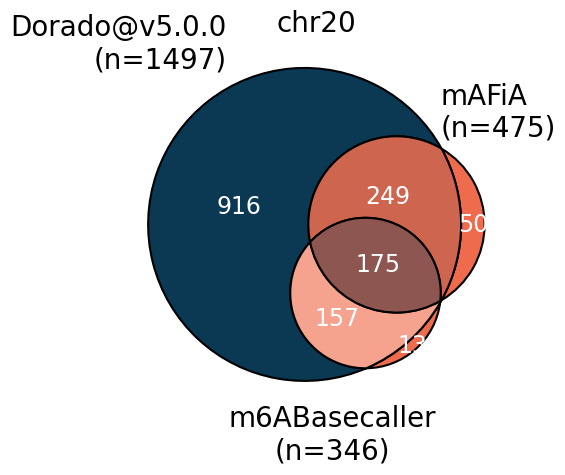

                            Intersection  Count
0                          Dorado@v5.0.0    916
1                                  mAFiA     50
2                          m6ABasecaller     13
3                  Dorado@v5.0.0 ∩ mAFiA    249
4          Dorado@v5.0.0 ∩ m6ABasecaller    157
5                  mAFiA ∩ m6ABasecaller      1
6  Dorado@v5.0.0 ∩ mAFiA ∩ m6ABasecaller    175


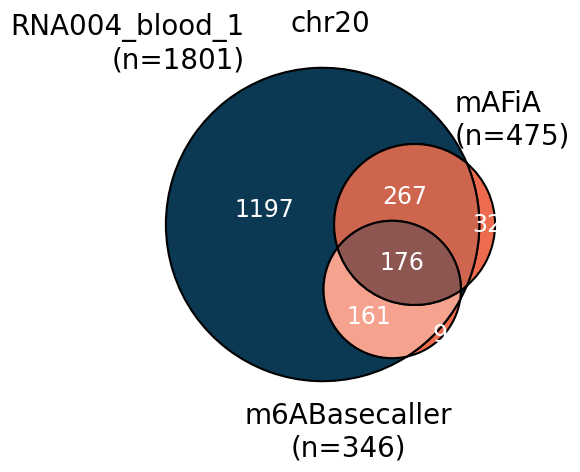

                             Intersection  Count
0                          RNA004_blood_1   1197
1                                   mAFiA     32
2                           m6ABasecaller      9
3                  RNA004_blood_1 ∩ mAFiA    267
4          RNA004_blood_1 ∩ m6ABasecaller    161
5                   mAFiA ∩ m6ABasecaller      0
6  RNA004_blood_1 ∩ mAFiA ∩ m6ABasecaller    176


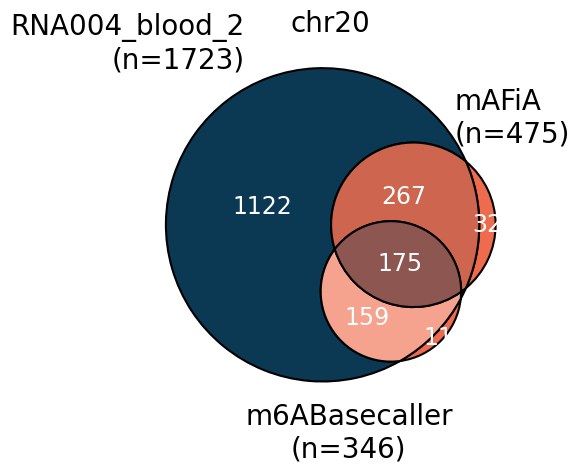

                             Intersection  Count
0                          RNA004_blood_2   1122
1                                   mAFiA     32
2                           m6ABasecaller     11
3                  RNA004_blood_2 ∩ mAFiA    267
4          RNA004_blood_2 ∩ m6ABasecaller    159
5                   mAFiA ∩ m6ABasecaller      1
6  RNA004_blood_2 ∩ mAFiA ∩ m6ABasecaller    175


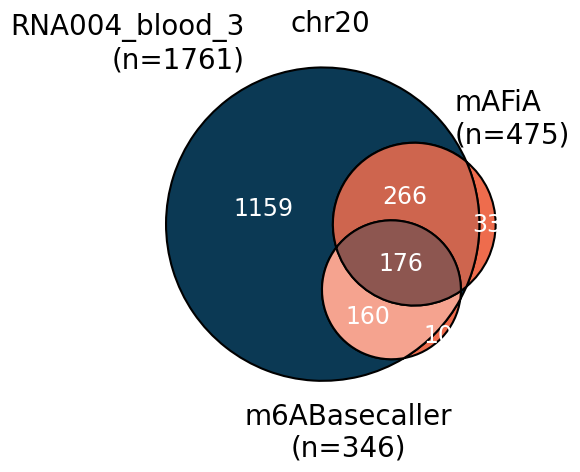

                             Intersection  Count
0                          RNA004_blood_3   1159
1                                   mAFiA     33
2                           m6ABasecaller     10
3                  RNA004_blood_3 ∩ mAFiA    266
4          RNA004_blood_3 ∩ m6ABasecaller    160
5                   mAFiA ∩ m6ABasecaller      0
6  RNA004_blood_3 ∩ mAFiA ∩ m6ABasecaller    176


In [28]:
# Extract sites from blood samples only
p_cov10_chr20_blood = p_cov10_chr20[p_cov10_chr20["sample"].isin(["RNA002_blood", "RNA004_blood_1", "RNA004_blood_2", "RNA004_blood_3"])]

# Extract sites that are covered by RNA002 blood with at least 10 reads
p_cov10_chr20_blood_002_covered = p_cov10_chr20_blood[p_cov10_chr20_blood["RNA002_blood"] >= 10]

# Extract sites that are covered by RNA002 blood with at least 10 reads and modified with frequency >= 10
p_cov10_freq10_chr20_blood_002_covered = p_cov10_chr20_blood_002_covered[p_cov10_chr20_blood_002_covered["modRatio"] >= 10 ]

# Extract sites per RNA004 blood sample with m6A freq >= 10 and RNA002 blood coverage >= 10
blood_1_RNA004_chr20_m6A_sites = p_cov10_freq10_chr20_blood_002_covered[p_cov10_freq10_chr20_blood_002_covered["sample"] == "RNA004_blood_1"].pos
blood_2_RNA004_chr20_m6A_sites = p_cov10_freq10_chr20_blood_002_covered[p_cov10_freq10_chr20_blood_002_covered["sample"] == "RNA004_blood_2"].pos
blood_3_RNA004_chr20_m6A_sites = p_cov10_freq10_chr20_blood_002_covered[p_cov10_freq10_chr20_blood_002_covered["sample"] == "RNA004_blood_3"].pos

# Intersect significant m6A sites between all three RNA004 blood samples that are covered by RNA002 blood
blood_RNA004_chr20_m6A_joined = set(blood_1_RNA004_chr20_m6A_sites) & set(blood_2_RNA004_chr20_m6A_sites) & set(blood_3_RNA004_chr20_m6A_sites)

# Extract significant m6A sites from mafia and m6Abasecaller with modRatio >= 10
mafia_m6A_sites = p_cov10_freq10_chr20_blood_002_covered[(p_cov10_freq10_chr20_blood_002_covered["sample"] == "RNA002_blood") & (p_cov10_freq10_chr20_blood_002_covered["caller"] == "mAFiA")]
m6ABasecaller_m6A_sites = p_cov10_freq10_chr20_blood_002_covered[(p_cov10_freq10_chr20_blood_002_covered["sample"] == "RNA002_blood") & (p_cov10_freq10_chr20_blood_002_covered["caller"] == "m6ABasecaller")]

# Extract significant m6A sites from mafia or m6Abasecaller that are covered in all three RNA004 samples
mafia_m6A_sites_cov = mafia_m6A_sites[(mafia_m6A_sites["RNA004_S5_DRS"] >= 10) & (mafia_m6A_sites["RNA004_S6_DRS"] >= 10) & (mafia_m6A_sites["RNA004_blood"] >= 10)]
m6ABasecaller_m6A_sites_cov = m6ABasecaller_m6A_sites[(m6ABasecaller_m6A_sites["RNA004_S5_DRS"] >= 10) & (m6ABasecaller_m6A_sites["RNA004_S6_DRS"] >= 10) & (m6ABasecaller_m6A_sites["RNA004_blood"] >= 10)]

# Plot overlap between RNA004 joined m6A sites and mafia and m6ABasecaller
tmp_dict = {"Dorado@v5.0.0" : blood_RNA004_chr20_m6A_joined, "mAFiA" : set(mafia_m6A_sites_cov.pos), "m6ABasecaller" : set(m6ABasecaller_m6A_sites_cov.pos)}
plot_overlaps(my_dict2 = tmp_dict, title_name = "chr20", out_file = "Blood_joined_RNA002_RNA004_chr20")

# Plot overlap between RNA004 sites per sample and mafia and m6ABasecaller
for blood_sample in ["RNA004_blood_1", "RNA004_blood_2", "RNA004_blood_3"]:
    tmp_dict = {blood_sample : set(p_cov10_freq10_chr20_blood_002_covered[p_cov10_freq10_chr20_blood_002_covered["sample"] == blood_sample].pos), "mAFiA" : set(mafia_m6A_sites_cov.pos), "m6ABasecaller" : set(m6ABasecaller_m6A_sites_cov.pos)}
    plot_overlaps(my_dict2 = tmp_dict, title_name = "chr20", out_file = "Blood_joined_RNA002_RNA004_" + blood_sample + "_chr20")



In [29]:
p_cov10_chr20_blood_m6A = p_cov10_chr20_blood[p_cov10_chr20_blood["modRatio"] >= 10]
print(p_cov10_chr20_blood_m6A.groupby("sample").size().reset_index())

           sample     0
0    RNA002_blood   821
1  RNA004_blood_1  3253
2  RNA004_blood_2  2387
3  RNA004_blood_3  3960


### SUBSAMPLED RNA004 BLOOD SAMPLES: ALL SITES

In [30]:
subsampled_blood_m6A = glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/R2Q2/cov_sub_*_m6A.cov_sub_r1.mod.bed")
subsampled_blood_m6A

['/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/R2Q2/cov_sub_RNA004_S6_DRS_basecall.0.7.2.GRCh38_m6A.cov_sub_r1.mod.bed',
 '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/R2Q2/cov_sub_RNA004_blood.0.7.2.GRCh38_m6A.cov_sub_r1.mod.bed',
 '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/R2Q2/cov_sub_RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.cov_sub_r1.mod.bed']

In [ ]:
#for i in $( cat /home/awiercze/BED_FILE_LIST_subsampled_blood.txt); do echo $i; head $i; base_name=$( basename $i ); samtools depth -aa -b $i -@ 100 -H -o /home/awiercze/${base_name/.cov_sub_r1.mod.bed/.SUBSAMPLED_DEPTH.txt} /raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA002_blood.0.7.2.GRCh38.bam; done

In [31]:
# Load subsampled m6A sites
subsampled_blood_m6A = glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/R2Q2/cov_sub_*_m6A.cov_sub_r1.mod.bed")
mods_subsampled = pd.DataFrame()
for j in subsampled_blood_m6A:
    print(j)
    t_tmp = pd.read_csv(j, sep = "\t", header = None)
    #print(len(t_tmp))
    t_tmp.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', "mod_start", "mod_end", "color", "coverage", "modRatio", "n_mod", "n_canonical", "n_other_mod", "n_delete", "n_fail", "n_diff", "n_nocall"]

    modbed_depth = os.path.basename(j).replace(".cov_sub_r1.mod.bed", ".SUBSAMPLED_DEPTH.txt")
    mod_file_df = pd.read_csv("/home/awiercze/" + modbed_depth, sep = "\t")
    mod_file_df =mod_file_df.rename(columns = {"#CHROM" : "chrom",  "POS": "chromEnd"})
    mod_file_df.columns = [os.path.basename(i).replace("_basecall", "").replace(".GRCh38.bam","").replace(".0.7.2", "") for i in mod_file_df.columns]
    #print(len(t_tmp))
    t_tmp = pd.merge(t_tmp,mod_file_df, on = ["chrom",  "chromEnd"], how = "left")
    #print(len(t_tmp))
    t_tmp = t_tmp[["chrom", "chromStart", "chromEnd", "name", "score", "strand", "coverage", "modRatio", "RNA002_blood"]]
    caller = "Dorado@v5.0.0"
    sample_name = j.split("/")[-1].replace("cov_sub_", "")
    for word, initial in replace_dict.items():
        sample_name = sample_name.replace(word, initial)
    print(sample_name)
    t_tmp["sample"] =sample_name
    t_tmp["caller"] = caller
    t_tmp["chemistry"] = "RNA004"
    mods_subsampled = pd.concat([mods_subsampled, t_tmp], axis = 0)
    
for j in blood_RNA002:
    print(j)
    #print(t_tmp.columns)
    #t_tmp.columns = ["chrom", "start", "end", "mod_code", "score", "strand", "mod_start", "mod_end", "color", "n_valid_cov", "frac_mod", "n_mod", "n_canonical", "n_other_mod", "n_delete", "n_fail", "n_diff", "n_nocall"]
    if "rodan" in j:
        t_tmp = pd.read_csv(j, sep = "\t", header = 0)
        #print(len(t_tmp))
        caller = "mAFiA"
        modbed_depth = os.path.basename(j).replace(".bed", ".SAMPLES_DEPTH.txt")
        mod_file_df = pd.read_csv("/home/awiercze/" + modbed_depth, sep = "\t")
        mod_file_df =mod_file_df.rename(columns = {"#CHROM" : "chrom",  "POS": "chromEnd"})
        mod_file_df.columns = [os.path.basename(i).replace("_basecall", "").replace(".GRCh38.bam","").replace(".0.7.2", "") for i in mod_file_df.columns]
        #print(len(t_tmp))
        t_tmp = pd.merge(t_tmp,mod_file_df, on = ["chrom",  "chromEnd"], how = "left")
        #print(len(t_tmp))
        t_tmp = t_tmp[["chrom", "chromStart", "chromEnd", "name", "score", "strand", "coverage", "modRatio"] + t_tmp.columns[9:].to_list()]

    else:
        #print(j)
        t_tmp = pd.read_csv(j, sep = "\t", header = None)
        
        #print(len(t_tmp))

        t_tmp.columns = ["chrom", "chromStart", "chromEnd", "name", "score", "strand", "mod_start", "mod_end", "color", "coverage", "modRatio"]
        caller = "m6ABasecaller"
        
        modbed_depth = os.path.basename(j).replace(".bed", ".SAMPLES_DEPTH.txt")
        mod_file_df = pd.read_csv("/home/awiercze/" + modbed_depth, sep = "\t")
        mod_file_df =mod_file_df.rename(columns = {"#CHROM" : "chrom",  "POS": "chromEnd"})
        mod_file_df.columns = [os.path.basename(i).replace("_basecall", "").replace(".GRCh38.bam","").replace(".0.7.2", "") for i in mod_file_df.columns]
        #print(len(t_tmp))
        t_tmp = pd.merge(t_tmp,mod_file_df, on = ["chrom",  "chromEnd"], how = "left")
        #print(len(t_tmp))
        t_tmp = t_tmp[["chrom", "chromStart", "chromEnd", "name", "score", "strand", "coverage", "modRatio"] + t_tmp.columns[11:].to_list()]
        
        
    t_tmp["sample"] = j.split("/")[-1].replace(".bed", "")
    t_tmp["sample"] = t_tmp["sample"].replace("final_blood_IVT_002_rodan_chr20_mAFiA.sites", "RNA002_blood_IVT")
    t_tmp["sample"] = t_tmp["sample"].replace("final_blood_002_rodan_chr20_mAFiA.sites", "RNA002_blood")
    t_tmp["sample"] = t_tmp["sample"].replace("m6A_basecaller_blood_mod", "RNA002_blood")
    t_tmp["sample"] = t_tmp["sample"].replace("m6A_basecaller_lemke_blood_IVT_mod", "RNA002_blood_IVT")
    t_tmp["caller"] = caller
    t_tmp["chemistry"] = "RNA002"
    t_tmp = t_tmp[t_tmp["chrom"].str.contains("chr20")]

    mods_subsampled = pd.concat([mods_subsampled, t_tmp], axis = 0)

mods_subsampled = mods_subsampled.reset_index()
mods_subsampled = mods_subsampled.drop("index", axis = 1)
mods_subsampled["chromStart"] = mods_subsampled["chromStart"].astype(int)
mods_subsampled["chromEnd"] = mods_subsampled["chromEnd"].astype(int)
mods_subsampled["coverage"] = mods_subsampled["coverage"].astype(int)
mods_subsampled["modRatio"] = mods_subsampled["modRatio"].astype(float)

mods_subsampled = mods_subsampled[mods_subsampled["chrom"].str.contains("chr")]
mods_subsampled["pos"] = mods_subsampled["chrom"] + ":" + mods_subsampled["chromStart"].astype(str) + "" + mods_subsampled["strand"]
mods_subsampled_cov10 = mods_subsampled[(mods_subsampled["coverage"] >= 10)]
mods_subsampled_cov10_chr20 = mods_subsampled[(mods_subsampled["coverage"] >= 10) & (mods_subsampled["chrom"] == "chr20")]
mods_subsampled_cov10_chr20_freq10 = mods_subsampled[(mods_subsampled["coverage"] >= 10) & (mods_subsampled["chrom"] == "chr20") & (mods_subsampled["modRatio"] >= 10)]
DORADO_subsampled = mods_subsampled_cov10[mods_subsampled_cov10["caller"] == "Dorado@v5.0.0"]
DORADO_subsampled["caller"] = "Dorado@v5.0.0_SUBSAMPLED"


/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/R2Q2/cov_sub_RNA004_S6_DRS_basecall.0.7.2.GRCh38_m6A.cov_sub_r1.mod.bed
RNA004_blood_3
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/R2Q2/cov_sub_RNA004_blood.0.7.2.GRCh38_m6A.cov_sub_r1.mod.bed
RNA004_blood_1
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/R2Q2/cov_sub_RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.cov_sub_r1.mod.bed
RNA004_blood_2
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/CHR20_BAMS/RNA002_folder/m6A_basecaller_blood_mod.bed
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/CHR20_BAMS/RNA002_folder/m6A_basecaller_lemke_blood_IVT_mod.bed
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/CHR20_BAMS/final_blood_IVT_002_rodan_chr20_mAFiA.sites.bed
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/CHR20_BAMS/final_blood_002_rodan_chr20_mAFiA.sites.bed


/tmp/ipykernel_4065922/689212698.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DORADO_subsampled["caller"] = "Dorado@v5.0.0_SUBSAMPLED"


/tmp/ipykernel_2908656/3235538279.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DORADO_subsampled["caller"] = "Dorado@v5.0.0_SUBSAMPLED"


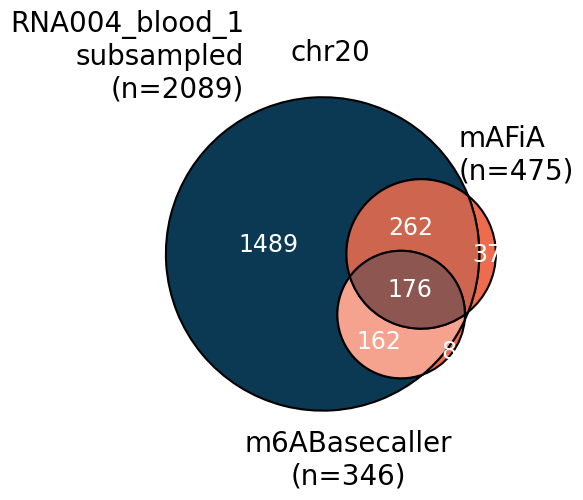

                                        Intersection  Count
0                         RNA004_blood_1\nsubsampled   1489
1                                              mAFiA     37
2                                      m6ABasecaller      8
3                 RNA004_blood_1\nsubsampled ∩ mAFiA    262
4         RNA004_blood_1\nsubsampled ∩ m6ABasecaller    162
5                              mAFiA ∩ m6ABasecaller      0
6  RNA004_blood_1\nsubsampled ∩ mAFiA ∩ m6ABaseca...    176


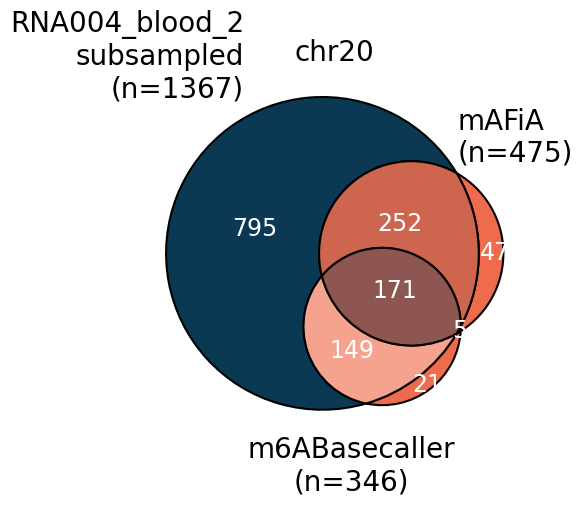

                                        Intersection  Count
0                         RNA004_blood_2\nsubsampled    795
1                                              mAFiA     47
2                                      m6ABasecaller     21
3                 RNA004_blood_2\nsubsampled ∩ mAFiA    252
4         RNA004_blood_2\nsubsampled ∩ m6ABasecaller    149
5                              mAFiA ∩ m6ABasecaller      5
6  RNA004_blood_2\nsubsampled ∩ mAFiA ∩ m6ABaseca...    171


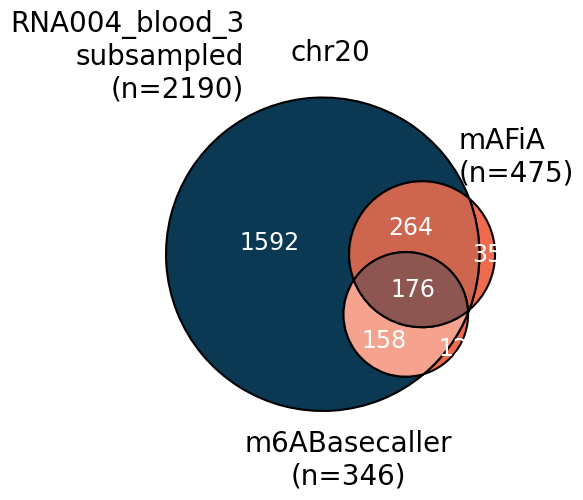

                                        Intersection  Count
0                         RNA004_blood_3\nsubsampled   1592
1                                              mAFiA     35
2                                      m6ABasecaller     12
3                 RNA004_blood_3\nsubsampled ∩ mAFiA    264
4         RNA004_blood_3\nsubsampled ∩ m6ABasecaller    158
5                              mAFiA ∩ m6ABasecaller      0
6  RNA004_blood_3\nsubsampled ∩ mAFiA ∩ m6ABaseca...    176


In [380]:
mods_subsampled = mods_subsampled[mods_subsampled["chrom"].str.contains("chr")]
mods_subsampled["pos"] = mods_subsampled["chrom"] + ":" + mods_subsampled["chromStart"].astype(str) + "" + mods_subsampled["strand"]
mods_subsampled_cov10 = mods_subsampled[(mods_subsampled["coverage"] >= 10)]
mods_subsampled_cov10_chr20 = mods_subsampled[(mods_subsampled["coverage"] >= 10) & (mods_subsampled["chrom"] == "chr20")]
mods_subsampled_cov10_chr20_freq10 = mods_subsampled[(mods_subsampled["coverage"] >= 10) & (mods_subsampled["chrom"] == "chr20") & (mods_subsampled["modRatio"] >= 10)]
DORADO_subsampled = mods_subsampled_cov10[mods_subsampled_cov10["caller"] == "Dorado@v5.0.0"]
DORADO_subsampled["caller"] = "Dorado@v5.0.0_SUBSAMPLED"

# Plot overlap between RNA004 sites per sample and mafia and m6ABasecaller
for blood_sample in ["RNA004_blood_1", "RNA004_blood_2", "RNA004_blood_3"]:
    blood_sample_name = blood_sample + "\nsubsampled"
    tmp_dict = {blood_sample_name : set(mods_subsampled_cov10_chr20_freq10[mods_subsampled_cov10_chr20_freq10["sample"] == blood_sample].pos), "mAFiA" : set(mafia_m6A_sites_cov.pos), "m6ABasecaller" : set(m6ABasecaller_m6A_sites_cov.pos)}
    plot_overlaps(my_dict2 = tmp_dict, title_name = "chr20", out_file = "Blood_RNA002_RNA004_subsampled_" + blood_sample + "_chr20")

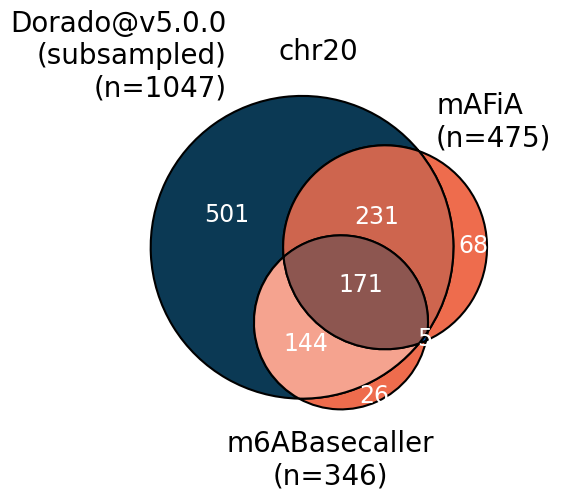

                                        Intersection  Count
0                        Dorado@v5.0.0\n(subsampled)    501
1                                              mAFiA     68
2                                      m6ABasecaller     26
3                Dorado@v5.0.0\n(subsampled) ∩ mAFiA    231
4        Dorado@v5.0.0\n(subsampled) ∩ m6ABasecaller    144
5                              mAFiA ∩ m6ABasecaller      5
6  Dorado@v5.0.0\n(subsampled) ∩ mAFiA ∩ m6ABasec...    171


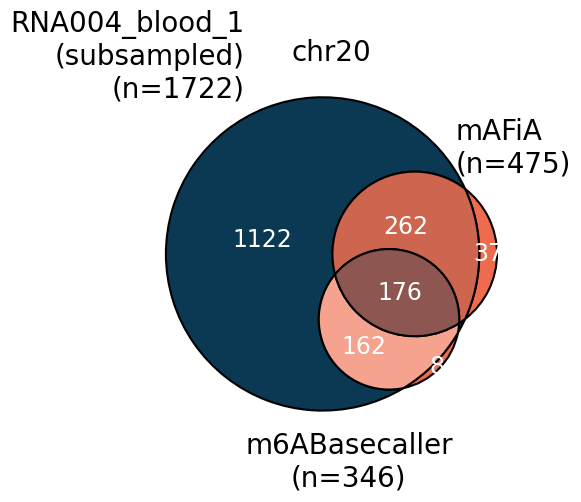

                                        Intersection  Count
0                       RNA004_blood_1\n(subsampled)   1122
1                                              mAFiA     37
2                                      m6ABasecaller      8
3               RNA004_blood_1\n(subsampled) ∩ mAFiA    262
4       RNA004_blood_1\n(subsampled) ∩ m6ABasecaller    162
5                              mAFiA ∩ m6ABasecaller      0
6  RNA004_blood_1\n(subsampled) ∩ mAFiA ∩ m6ABase...    176


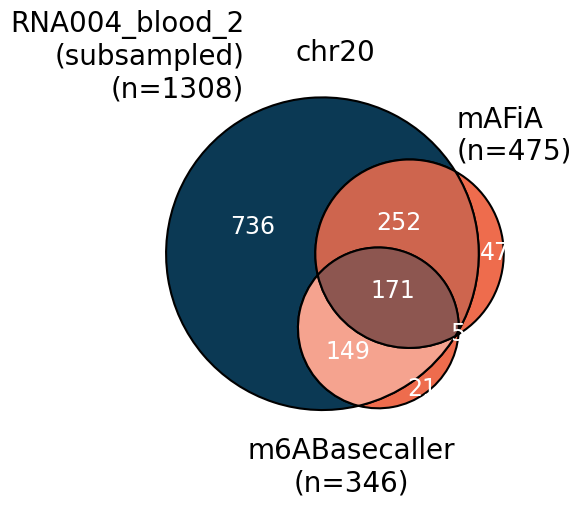

                                        Intersection  Count
0                       RNA004_blood_2\n(subsampled)    736
1                                              mAFiA     47
2                                      m6ABasecaller     21
3               RNA004_blood_2\n(subsampled) ∩ mAFiA    252
4       RNA004_blood_2\n(subsampled) ∩ m6ABasecaller    149
5                              mAFiA ∩ m6ABasecaller      5
6  RNA004_blood_2\n(subsampled) ∩ mAFiA ∩ m6ABase...    171


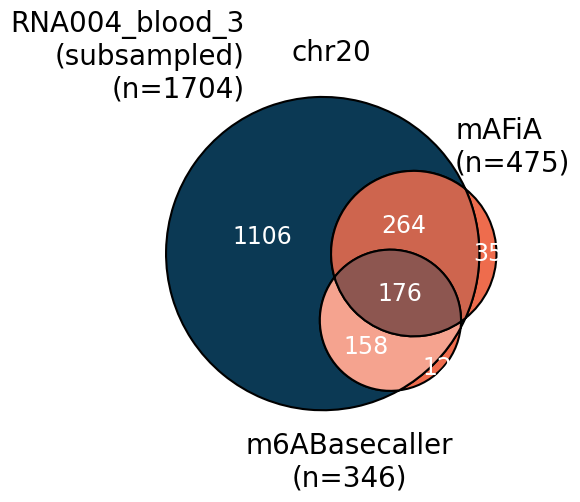

                                        Intersection  Count
0                       RNA004_blood_3\n(subsampled)   1106
1                                              mAFiA     35
2                                      m6ABasecaller     12
3               RNA004_blood_3\n(subsampled) ∩ mAFiA    264
4       RNA004_blood_3\n(subsampled) ∩ m6ABasecaller    158
5                              mAFiA ∩ m6ABasecaller      0
6  RNA004_blood_3\n(subsampled) ∩ mAFiA ∩ m6ABase...    176


In [32]:
# Extract sites from blood samples only
DORADO_subsampled_blood = mods_subsampled_cov10_chr20[mods_subsampled_cov10_chr20["sample"].isin(["RNA002_blood", "RNA004_blood_1", "RNA004_blood_2", "RNA004_blood_3"])]

# Extract sites that are covered by RNA002 blood with at least 10 reads
DORADO_subsampled_002_covered = DORADO_subsampled_blood[DORADO_subsampled_blood["RNA002_blood"] >= 10]

# Extract sites that are covered by RNA002 blood with at least 10 reads and modified with frequency >= 10
DORADO_subsampled_002_covered = DORADO_subsampled_002_covered[DORADO_subsampled_002_covered["modRatio"] >= 10 ]

# Extract sites per RNA004 blood sample with m6A freq >= 10 and RNA002 blood coverage >= 10
blood_1_RNA004_chr20_sub_m6A_sites = DORADO_subsampled_002_covered[DORADO_subsampled_002_covered["sample"] == "RNA004_blood_1"].pos
blood_2_RNA004_chr20_sub_m6A_sites = DORADO_subsampled_002_covered[DORADO_subsampled_002_covered["sample"] == "RNA004_blood_2"].pos
blood_3_RNA004_chr20_sub_m6A_sites = DORADO_subsampled_002_covered[DORADO_subsampled_002_covered["sample"] == "RNA004_blood_3"].pos

# Intersect significant m6A sites between all three RNA004 blood samples that are covered by RNA002 blood
blood_RNA004_chr20_sub_m6A_joined = set(blood_1_RNA004_chr20_sub_m6A_sites) & set(blood_2_RNA004_chr20_sub_m6A_sites) & set(blood_3_RNA004_chr20_sub_m6A_sites)

# Extract significant m6A sites from mafia and m6Abasecaller with modRatio >= 10
mafia_m6A_sites = DORADO_subsampled_002_covered[(DORADO_subsampled_002_covered["sample"] == "RNA002_blood") & (DORADO_subsampled_002_covered["caller"] == "mAFiA")]
m6ABasecaller_m6A_sites = DORADO_subsampled_002_covered[(DORADO_subsampled_002_covered["sample"] == "RNA002_blood") & (DORADO_subsampled_002_covered["caller"] == "m6ABasecaller")]

# Extract significant m6A sites from mafia or m6Abasecaller that are covered in all three RNA004 samples
mafia_m6A_sites_cov = mafia_m6A_sites
m6ABasecaller_m6A_sites_cov = m6ABasecaller_m6A_sites

# Plot overlap between RNA004 joined m6A sites and mafia and m6ABasecaller
tmp_dict = {"Dorado@v5.0.0\n(subsampled)" : blood_RNA004_chr20_sub_m6A_joined, "mAFiA" : set(mafia_m6A_sites_cov.pos), "m6ABasecaller" : set(m6ABasecaller_m6A_sites_cov.pos)}
plot_overlaps(my_dict2 = tmp_dict, title_name = "chr20", out_file = "Blood_joined_sub_RNA002_RNA004_chr20")

# Plot overlap between RNA004 sites per sample and mafia and m6ABasecaller
for blood_sample in ["RNA004_blood_1", "RNA004_blood_2", "RNA004_blood_3"]:
    tmp_dict = {blood_sample +"\n(subsampled)" : set(DORADO_subsampled_002_covered[DORADO_subsampled_002_covered["sample"] == blood_sample].pos), "mAFiA" : set(mafia_m6A_sites_cov.pos), "m6ABasecaller" : set(m6ABasecaller_m6A_sites_cov.pos)}
    plot_overlaps(my_dict2 = tmp_dict, title_name = "chr20", out_file = "Blood_joined_RNA002_RNA004_" + blood_sample + "_chr20_sub")



In [ ]:
DORADO_subsampled_blood.loc[DORADO_subsampled_blood["sample"].str.contains("RNA002"), "sample"] = DORADO_subsampled_blood[DORADO_subsampled_blood["sample"].str.contains("RNA002")]["sample"] + "_" + DORADO_subsampled_blood[DORADO_subsampled_blood["sample"].str.contains("RNA002")]["caller"]
DORADO_subsampled_blood.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand',
       'coverage', 'modRatio', 'RNA002_blood', 'sample', 'caller', 'chemistry',
       'RNA004_UHRR_2', 'RNA004_UHRR_1', 'RNA004_blood_IVT', 'RNA002_B',
       'RNA002_blood_IVT', 'RNA004_blood_1', 'RNA002_UHRR_1', 'RNA004_UHRR_3',
       'RNA004_A', 'RNA002_A', 'RNA004_B', 'RNA004_blood_3', 'RNA004_S6_IVT_LI',
       'RNA004_S6_IVT', 'RNA004_blood_2', 'pos']
DORADO_subsampled_blood["sample"] = [i + "_SUBSAMPLED" if "RNA004" in i else i for i in DORADO_subsampled_blood["sample"]]
comparisons_subsampled = [("RNA004_blood_1_SUBSAMPLED", "RNA002_blood_m6ABasecaller"), ("RNA004_blood_1_SUBSAMPLED", "RNA002_blood_mAFiA"), 
       ("RNA004_blood_2_SUBSAMPLED", "RNA002_blood_m6ABasecaller"), ("RNA004_blood_2_SUBSAMPLED", "RNA002_blood_mAFiA"),
       ("RNA004_blood_3_SUBSAMPLED", "RNA002_blood_m6ABasecaller"), ("RNA004_blood_3_SUBSAMPLED", "RNA002_blood_mAFiA")]


df = DORADO_subsampled_blood[DORADO_subsampled_blood["modRatio"] >= 10]
result_rows = []
# Iterate over all pairwise combinations of all samples to calculate m6A ratio correlations between shared m6A sites
for s1, s2 in comparisons_subsampled:
    print(s1 + " vs " + s2)
    s1_depth = s1.replace("_SUBSAMPLED", "")
    s2_depth = s2.replace("blood_.*", "blood")
    df1_mod = df[df['sample'] == s1]
    df2_mod = df[df['sample'] == s2]
    
    target = "transcriptome-wide"
    
    if "RNA002" in s1 or "RNA002" in s2:
        df1_mod = df1_mod[df1_mod["chrom"] == "chr20"]    
        df2_mod = df2_mod[df2_mod["chrom"] == "chr20"]
        target = "chr20"


    # Positions with coverage >= 10 and modRatio >= 10
    pos_mod1 = set(df1_mod['pos'])
    pos_mod2 = set(df2_mod['pos'])

    # Joined positions
    joined_cov_mod = pos_mod1 & pos_mod2
    df1_mod_joined = df1_mod[df1_mod["RNA002_blood"] >= 10]
    df2_mod_joined = df2_mod[df2_mod[s1_depth] >= 10]

    joined_cov = set(df1_mod_joined['pos']) | set(df2_mod_joined['pos'])
    n_joined_cov = len(joined_cov)
        
    print(len(joined_cov_mod))
    if joined_cov_mod:
        df1_r2 = df1_mod[df1_mod['pos'].isin(joined_cov_mod)].set_index('pos')
        df2_r2 = df2_mod[df2_mod['pos'].isin(joined_cov_mod)].set_index('pos')
        df2_r2 = df2_r2.sort_values(by = "pos")
        df1_r2 = df1_r2.sort_values(by = "pos")
        mod1 = df1_r2.loc[df1_r2.index.isin(joined_cov_mod), 'modRatio']
        mod2 = df2_r2.loc[df1_r2.index.isin(joined_cov_mod), 'modRatio']
        r = pearsonr(mod1, mod2)
        r = r[0]
        corr = round(r, 4)
        print(corr)
        
        #input_set1 = df1_r2
        #input_set2 = df2_r2
        #m = pd.merge(input_set1.reset_index(), input_set2.reset_index(), how = "inner", on = "pos")
        #g = sns.jointplot(x="modRatio_x", y="modRatio_y", data=m, kind='hex', color="#0B3954",     height=3,        # default is 6
        #    ratio=5 )

        # Add correlation coefficient as text
        #g.fig.suptitle(f'Correlation (r) = {corr:.2f}' + f'\n(n = {len(m)})', fontsize=10)
        #g.set_axis_labels(s1,s2)
        #g.ax_joint.set_ylim(0, 100) 
        #g.ax_joint.set_xlim(0, 100) 
        #g.fig.subplots_adjust(top=0.9)  # make room for suptitle
        #comp = s1 + "_vs_" + s2
        #g.savefig("/home/awiercze/NEW_RNA004_PLOTS/Correlation_plot_" + comp + ".m6A.png", transparent=True, dpi = 300)
        #g.savefig("/home/awiercze/NEW_RNA004_PLOTS/Correlation_plot_" + comp + ".m6A.pdf", transparent=True, dpi = 300)
        #plt.close()
    else:
        corr = "NA"

    result_rows.append({
        'Sample1': s1,
        'Sample2': s2,
        "target" : target,
        'n_m6A_ratio>=10.Sample1': len(pos_mod1),
        'n_m6A_ratio>=10.Sample2': len(pos_mod2),
        'n_coverage_filter_passed*.Sample1_Sample2': n_joined_cov,
        'n_m6A_ratio>=10.Sample1_joined_cov': len(df1_mod_joined),
        'n_m6A_ratio>=10.Sample2_joined_cov': len(df2_mod_joined),
        'n_m6A_ratio>=10.Sample1_Sample2': len(joined_cov_mod),
        'mean_m6A_ratio.Sample1_joined_mod' : np.mean(mod1),
        'median_m6A_ratio.Sample1_joined_mod' : np.median(mod1),
        'mean_m6A_ratio.Sample2_joined_mod' : np.mean(mod2) ,
        'median_m6A_ratio.Sample2_joined_mod' : np.median(mod2) ,
        'Correlation_coeff_joined_cov_and_mod': corr
    })
    
# Final result DataFrame
comparison_df = pd.DataFrame(result_rows)
comparison_df.to_csv("/home/awiercze/NEW_RNA004_PLOTS/TABLES/PAPER_TABLE_r2_values_all_pairwise_comps_m6A_new_SUBSAMPLED.tsv", sep = "\t", index = False)

RNA004_blood_1_SUBSAMPLED vs RNA002_blood_m6ABasecaller
338
0.5961
RNA004_blood_1_SUBSAMPLED vs RNA002_blood_mAFiA
438
0.8647
RNA004_blood_2_SUBSAMPLED vs RNA002_blood_m6ABasecaller
320
0.5916
RNA004_blood_2_SUBSAMPLED vs RNA002_blood_mAFiA
423
0.8427
RNA004_blood_3_SUBSAMPLED vs RNA002_blood_m6ABasecaller
334
0.577
RNA004_blood_3_SUBSAMPLED vs RNA002_blood_mAFiA
440
0.8493


/tmp/ipykernel_4065922/460073508.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DORADO_subsampled_blood["sample"] = [i + "_SUBSAMPLED" if "RNA004" in i else i for i in DORADO_subsampled_blood["sample"]]


In [34]:
comparison_df

,Sample1,Sample2,target,n_m6A_ratio>=10.Sample1,n_m6A_ratio>=10.Sample2,n_coverage_filter_passed*.Sample1_Sample2,n_m6A_ratio>=10.Sample1_joined_cov,n_m6A_ratio>=10.Sample2_joined_cov,n_m6A_ratio>=10.Sample1_Sample2,mean_m6A_ratio.Sample1_joined_mod,median_m6A_ratio.Sample1_joined_mod,mean_m6A_ratio.Sample2_joined_mod,median_m6A_ratio.Sample2_joined_mod,Correlation_coeff_joined_cov_and_mod
0,RNA004_blood_1_SUBSAMPLED,RNA002_blood_m6ABasecaller,chr20,2089,346,1730,1722,346,338,60.794201,63.815,26.600592,23.0,0.5961
1,RNA004_blood_1_SUBSAMPLED,RNA002_blood_mAFiA,chr20,2089,475,1759,1722,475,438,44.341986,36.380,43.413242,38.0,0.8647
2,RNA004_blood_2_SUBSAMPLED,RNA002_blood_m6ABasecaller,chr20,1367,346,1334,1308,346,320,60.180844,63.015,26.728125,23.0,0.5916
3,RNA004_blood_2_SUBSAMPLED,RNA002_blood_mAFiA,chr20,1367,475,1360,1308,475,423,44.464681,37.500,43.607565,38.0,0.8427
4,RNA004_blood_3_SUBSAMPLED,RNA002_blood_m6ABasecaller,chr20,2190,346,1716,1704,346,334,61.031856,63.510,26.736527,23.0,0.5770
5,RNA004_blood_3_SUBSAMPLED,RNA002_blood_mAFiA,chr20,2190,475,1739,1704,475,440,44.060432,35.950,43.284091,38.0,0.8493


# OVERLAP OF REPLICATES

## BLOOD

In [36]:
def plot_overlaps_blood(my_dict2, title_name, out_name):
    sets = list(my_dict2.values())
    labels = list(my_dict2.keys())
    labels[0] = labels[0] + "\n(n=" + str(len(my_dict2[labels[0]]))  + ")"
    labels[1] = labels[1] + "\n(n=" + str(len(my_dict2[labels[1]])) + ")"
    labels[2] = labels[2] + "\n(n=" + str(len(my_dict2[labels[2]]))  + ")"

    # Create Venn diagram
    venn = venn3(subsets=sets, set_labels=labels)

    venn.get_patch_by_id('100').set_color("#1F97DD")   
    venn.get_patch_by_id('010').set_color("#53ABDF")   
    venn.get_patch_by_id('001').set_color("#84BADA")   
    venn.get_patch_by_id('110').set_color("#176796")   
    venn.get_patch_by_id('101').set_color("#4E7F9B")   
    venn.get_patch_by_id('111').set_color("#0B3954")  
    venn.get_patch_by_id('011').set_color("#5B839B")   


    venn.get_label_by_id('100').set_color("white")   
    venn.get_label_by_id('010').set_color("white")   
    venn.get_label_by_id('001').set_color("white")  
    venn.get_label_by_id('110').set_color("white")   
    venn.get_label_by_id('101').set_color("white")   
    venn.get_label_by_id('111').set_color("white")   
    venn.get_label_by_id('011').set_color("white")  

    venn.get_label_by_id('100').set_fontsize(7)
    venn.get_label_by_id('010').set_fontsize(7)
    venn.get_label_by_id('001').set_fontsize(7)
    venn.get_label_by_id('110').set_fontsize(7)
    venn.get_label_by_id('101').set_fontsize(7)
    venn.get_label_by_id('111').set_fontsize(17)
    venn.get_label_by_id('011').set_fontsize(7)

    for patch in venn.patches:
        if patch:  
            patch.set_edgecolor("black")
            patch.set_linewidth(2) 
            patch.set_alpha(1)
            print(patch.get_label())
    for text in venn.set_labels:
        if text:
            text.set_fontsize(20)  

    plt.title(title_name, fontsize = 20)
    plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/Overlapping_covered_blood_RNA004_blood_cov10_freq10_replicates_" + out_name + ".pdf", dpi=300, bbox_inches='tight', transparent=True)

    plt.show()

### ALL SITES

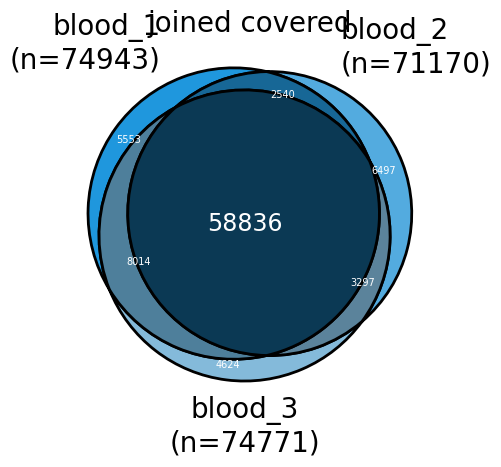

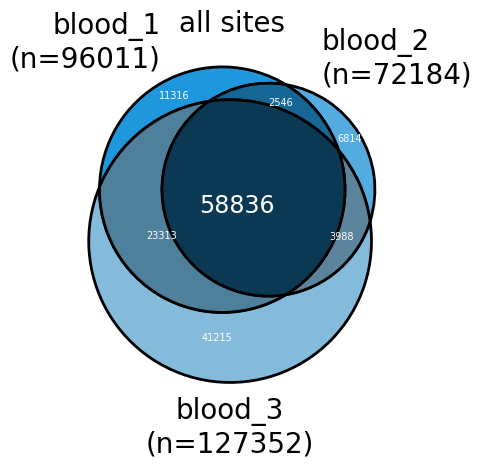

In [37]:
# Extract sites per RNA004 blood sample with m6A freq >= 10 and RNA002 blood coverage >= 10
blood_1_RNA004_m6A_sites = p_cov10[(p_cov10["sample"] == "RNA004_blood_1") & (p_cov10["modRatio"] >= 10)]
blood_2_RNA004_m6A_sites = p_cov10[(p_cov10["sample"] == "RNA004_blood_2") & (p_cov10["modRatio"] >= 10)]
blood_3_RNA004_m6A_sites = p_cov10[(p_cov10["sample"] == "RNA004_blood_3") & (p_cov10["modRatio"] >= 10)]

# Extract sites per RNA004 blood sample with m6A freq >= 10 and RNA002 blood coverage >= 10
blood_1_RNA004_m6A_sites_joined = blood_1_RNA004_m6A_sites[(blood_1_RNA004_m6A_sites["RNA004_S5_DRS"] >= 10 ) & (blood_1_RNA004_m6A_sites["RNA004_S6_DRS"] >= 10)]
blood_2_RNA004_m6A_sites_joined = blood_2_RNA004_m6A_sites[(blood_2_RNA004_m6A_sites["RNA004_blood"] >= 10 ) & (blood_2_RNA004_m6A_sites["RNA004_S6_DRS"] >= 10)]
blood_3_RNA004_m6A_sites_joined = blood_3_RNA004_m6A_sites[(blood_3_RNA004_m6A_sites["RNA004_S5_DRS"] >= 10 ) & (blood_3_RNA004_m6A_sites["RNA004_blood"] >= 10)]

# Plot overlap between RNA004 joined m6A sites of all three replicates
tmp_dict = {"blood_1" : set(blood_1_RNA004_m6A_sites_joined.pos), "blood_2" : set(blood_2_RNA004_m6A_sites_joined.pos), "blood_3" : set(blood_3_RNA004_m6A_sites_joined.pos)}
plot_overlaps_blood(my_dict2 = tmp_dict, title_name = "joined covered", out_name = "Blood_joined_RNA004_replicates")

# Plot overlap between RNA004 sites per sample of all sites
tmp_dict = {"blood_1" : set(blood_1_RNA004_m6A_sites.pos), "blood_2" : set(blood_2_RNA004_m6A_sites.pos), "blood_3" : set(blood_3_RNA004_m6A_sites.pos)}
plot_overlaps_blood(my_dict2 = tmp_dict, title_name = "all sites", out_name = "Blood_all_sites_RNA004_replicates")


### MENDELIOME SITES ONLY

In [38]:
query_ranges = pr.PyRanges(p_cov10.rename(columns = {"chrom": "Chromosome", "chromStart" : "Start", "chromEnd" : "End", "strand" : "Strand"}))
result_annot = gtf_ranges.join(query_ranges, how="right")
result_annot_df = result_annot.df

In [39]:
mendeliom = pd.read_csv("/raid/awiercze_analysis/RESEARCH/REVISION_FIGURES/mendeliom_IHDB.tsv", sep = "\t")
result_annot_df["gene_id_flat"] = [i.split('.')[0] for i in result_annot_df.gene_id]
result_annot_df_mendel = result_annot_df[result_annot_df["gene_id_flat"].isin(mendeliom.ensembl_gene_id)]

In [40]:
# Extract sites per RNA004 blood sample with m6A freq >= 10 and RNA002 blood coverage >= 10
blood_1_RNA004_m6A_sites_mendel = result_annot_df_mendel[(result_annot_df_mendel["sample"] == "RNA004_blood_1") & (result_annot_df_mendel["modRatio"] >= 10)]
blood_2_RNA004_m6A_sites_mendel = result_annot_df_mendel[(result_annot_df_mendel["sample"] == "RNA004_blood_2") & (result_annot_df_mendel["modRatio"] >= 10)]
blood_3_RNA004_m6A_sites_mendel = result_annot_df_mendel[(result_annot_df_mendel["sample"] == "RNA004_blood_3") & (result_annot_df_mendel["modRatio"] >= 10)]

print("Blood1:" + str(len(blood_1_RNA004_m6A_sites_mendel.pos.drop_duplicates())))
print("Blood2:"+ str(len(blood_2_RNA004_m6A_sites_mendel.pos.drop_duplicates())))
print("Blood3:" + str(len(blood_3_RNA004_m6A_sites_mendel.pos.drop_duplicates())))


Blood1:30585
Blood2:23627
Blood3:39257


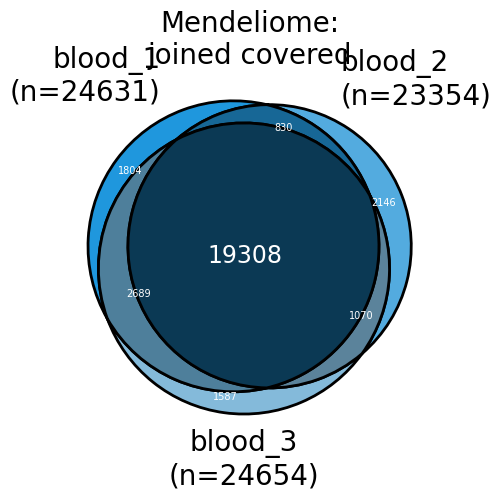

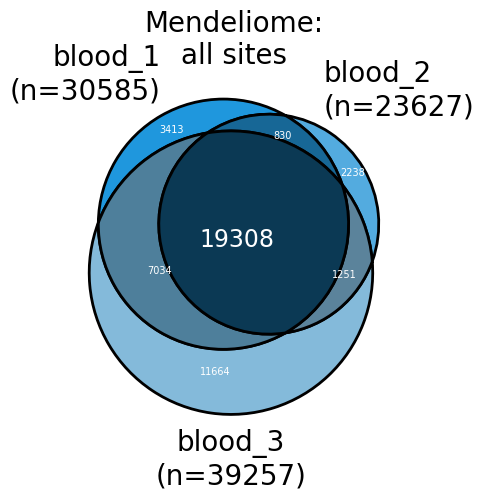

In [41]:
# Extract sites per RNA004 blood sample with m6A freq >= 10 and RNA002 blood coverage >= 10
blood_1_RNA004_m6A_sites_joined_mendel = blood_1_RNA004_m6A_sites_mendel[(blood_1_RNA004_m6A_sites_mendel["RNA004_S5_DRS"] >= 10 ) & (blood_1_RNA004_m6A_sites_mendel["RNA004_S6_DRS"] >= 10)]
blood_2_RNA004_m6A_sites_joined_mendel = blood_2_RNA004_m6A_sites_mendel[(blood_2_RNA004_m6A_sites_mendel["RNA004_blood"] >= 10 ) & (blood_2_RNA004_m6A_sites_mendel["RNA004_S6_DRS"] >= 10)]
blood_3_RNA004_m6A_sites_joined_mendel = blood_3_RNA004_m6A_sites_mendel[(blood_3_RNA004_m6A_sites_mendel["RNA004_S5_DRS"] >= 10 ) & (blood_3_RNA004_m6A_sites_mendel["RNA004_blood"] >= 10)]

# Plot overlap between RNA004 joined m6A sites of all three replicates
tmp_dict = {"blood_1" : set(blood_1_RNA004_m6A_sites_joined_mendel.pos), "blood_2" : set(blood_2_RNA004_m6A_sites_joined_mendel.pos), "blood_3" : set(blood_3_RNA004_m6A_sites_joined_mendel.pos)}
plot_overlaps_blood(my_dict2 = tmp_dict, title_name = "Mendeliome:\njoined covered", out_name = "Blood_joined_mendel_sites_RNA004_replicates")

# Plot overlap between RNA004 sites per sample of all sites
tmp_dict = {"blood_1" : set(blood_1_RNA004_m6A_sites_mendel.pos), "blood_2" : set(blood_2_RNA004_m6A_sites_mendel.pos), "blood_3" : set(blood_3_RNA004_m6A_sites_mendel.pos)}
plot_overlaps_blood(my_dict2 = tmp_dict, title_name = "Mendeliome:\nall sites", out_name = "Blood_all_mendel_sites_RNA004_replicates")

## CELL-LINES

In [42]:
def plot_overlaps_UHRR(my_dict2, title_name, out_name):
    sets = list(my_dict2.values())
    labels = list(my_dict2.keys())
    labels[0] = labels[0] + "\n(n=" + str(len(my_dict2[labels[0]]))  + ")"
    labels[1] = labels[1] + "\n(n=" + str(len(my_dict2[labels[1]])) + ")"
    labels[2] = labels[2] + "\n(n=" + str(len(my_dict2[labels[2]]))  + ")"

    # Create Venn diagram
    venn = venn3(subsets=sets, set_labels=labels)

    venn.get_patch_by_id('100').set_color("#4DAFB9")   
    venn.get_patch_by_id('010').set_color("#5DBBC5")   
    venn.get_patch_by_id('001').set_color("#638D92")   
    venn.get_patch_by_id('110').set_color("#10C1D4")   
    venn.get_patch_by_id('101').set_color("#5ADAE9")   
    venn.get_patch_by_id('111').set_color("#098C9A")  
    venn.get_patch_by_id('011').set_color("#8AD8E0")   


    venn.get_label_by_id('100').set_color("white")   
    venn.get_label_by_id('010').set_color("white")   
    venn.get_label_by_id('001').set_color("white")  
    venn.get_label_by_id('110').set_color("white")   
    venn.get_label_by_id('101').set_color("white")   
    venn.get_label_by_id('111').set_color("white")   
    venn.get_label_by_id('011').set_color("white")  

    venn.get_label_by_id('100').set_fontsize(7)
    venn.get_label_by_id('010').set_fontsize(7)
    venn.get_label_by_id('001').set_fontsize(7)
    venn.get_label_by_id('110').set_fontsize(7)
    venn.get_label_by_id('101').set_fontsize(7)
    venn.get_label_by_id('111').set_fontsize(17)
    venn.get_label_by_id('011').set_fontsize(7)

    for patch in venn.patches:
        if patch:  
            patch.set_edgecolor("black")
            patch.set_linewidth(2) 
            patch.set_alpha(1)
            print(patch.get_label())

    for text in venn.set_labels:
        if text:
            text.set_fontsize(20)  

    plt.title(title_name, fontsize = 20)
    plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/Overlapping_covered_RNA004_UHRR_cov10_freq10_replicates_" + out_name + ".pdf", dpi=300, bbox_inches='tight', transparent=True)

    plt.show()
    

### UHRR

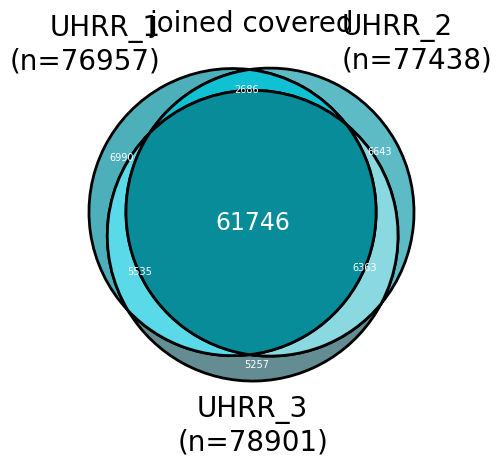

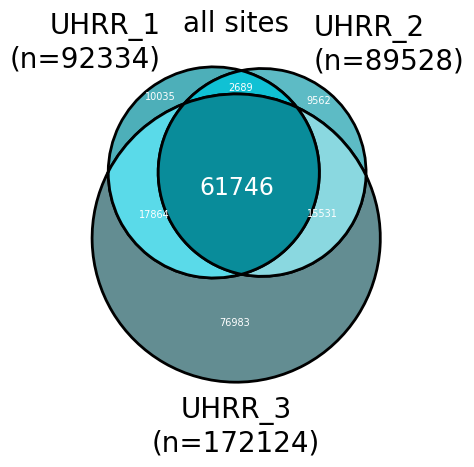

In [44]:
# Extract sites per RNA004 blood sample with m6A freq >= 10 and RNA002 blood coverage >= 10
UHRR_1_RNA004_m6A_sites = p_m6A_cell_cov10[(p_m6A_cell_cov10["sample"] == "RNA004_UHRR_1") & (p_m6A_cell_cov10["modRatio"] >= 10)]
UHRR_2_RNA004_m6A_sites = p_m6A_cell_cov10[(p_m6A_cell_cov10["sample"] == "RNA004_UHRR_2") & (p_m6A_cell_cov10["modRatio"] >= 10)]
UHRR_3_RNA004_m6A_sites = p_m6A_cell_cov10[(p_m6A_cell_cov10["sample"] == "RNA004_UHRR_3") & (p_m6A_cell_cov10["modRatio"] >= 10)]

# Extract sites per RNA004 blood sample with m6A freq >= 10 and RNA002 blood coverage >= 10
UHRR_1_RNA004_m6A_sites_joined = UHRR_1_RNA004_m6A_sites[(UHRR_1_RNA004_m6A_sites["RNA004_UHRR_2"] >= 10 ) & (UHRR_1_RNA004_m6A_sites["RNA004_UHRR_3"] >= 10)]
UHRR_2_RNA004_m6A_sites_joined = UHRR_2_RNA004_m6A_sites[(UHRR_2_RNA004_m6A_sites["RNA004_UHRR_1"] >= 10 ) & (UHRR_2_RNA004_m6A_sites["RNA004_UHRR_3"] >= 10)]
UHRR_3_RNA004_m6A_sites_joined = UHRR_3_RNA004_m6A_sites[(UHRR_3_RNA004_m6A_sites["RNA004_UHRR_1"] >= 10 ) & (UHRR_3_RNA004_m6A_sites["RNA004_UHRR_2"] >= 10)]

# Plot overlap between RNA004 joined m6A sites of all three replicates
tmp_dict = {"UHRR_1" : set(UHRR_1_RNA004_m6A_sites_joined.pos), "UHRR_2" : set(UHRR_2_RNA004_m6A_sites_joined.pos), "UHRR_3" : set(UHRR_3_RNA004_m6A_sites_joined.pos)}
plot_overlaps_UHRR(my_dict2 = tmp_dict, title_name = "joined covered", out_name = "UHRR_joined_RNA004_replicates")

# Plot overlap between RNA004 sites per sample of all sites
tmp_dict = {"UHRR_1" : set(UHRR_1_RNA004_m6A_sites.pos), "UHRR_2" : set(UHRR_2_RNA004_m6A_sites.pos), "UHRR_3" : set(UHRR_3_RNA004_m6A_sites.pos)}
plot_overlaps_UHRR(my_dict2 = tmp_dict, title_name = "all sites", out_name = "UHRR_all_sites_RNA004_replicates")


### HEK293T

In [45]:
def plot_overlaps_HEK293T(my_dict2, title_name, out_name):
    sets = list(my_dict2.values())
    labels = list(my_dict2.keys())
    labels[0] = labels[0] + "\n(n=" + str(len(my_dict2[labels[0]]))  + ")"
    labels[1] = labels[1] + "\n(n=" + str(len(my_dict2[labels[1]])) + ")"

    # Create Venn diagram
    venn = venn2(subsets=sets, set_labels=labels)

    venn.get_patch_by_id('10').set_color("#F5BAAC")   
    venn.get_patch_by_id('01').set_color("#EE6C4D")   
    venn.get_patch_by_id('11').set_color("#EB9782")   

    venn.get_label_by_id('10').set_color("white")   
    venn.get_label_by_id('01').set_color("white")   
    venn.get_label_by_id('11').set_color("white")  

    venn.get_label_by_id('10').set_fontsize(7)
    venn.get_label_by_id('11').set_fontsize(17)
    venn.get_label_by_id('01').set_fontsize(7)

    for patch in venn.patches:
        if patch:  
            patch.set_edgecolor("black")
            patch.set_linewidth(2) 
            patch.set_alpha(1)
            print(patch.get_label())

    for text in venn.set_labels:
        if text:
            text.set_fontsize(20)  

    plt.title(title_name, fontsize = 20)
    
    plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/Overlapping_covered_HEK293T_RNA004_cov10_freq10_replicates_" + out_name + ".pdf", dpi=300, bbox_inches='tight', transparent=True)

    plt.show()

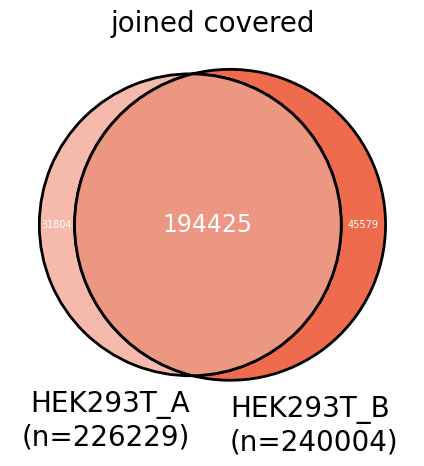

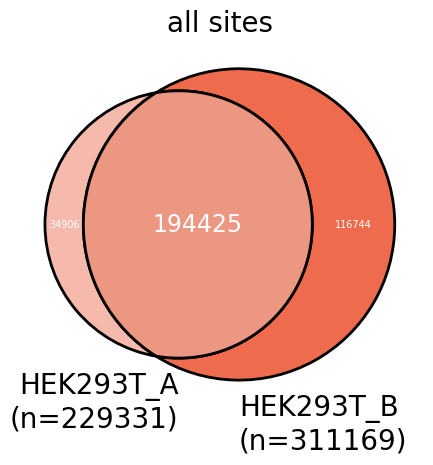

In [46]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn2, venn2_circles


# Extract sites per RNA004 blood sample with m6A freq >= 10 and RNA002 blood coverage >= 10
HEK_A_RNA004_m6A_sites = p_m6A_cell_cov10[(p_m6A_cell_cov10["sample"] == "RNA004_HEK293T_A") & (p_m6A_cell_cov10["modRatio"] >= 10)]
HEK_B_RNA004_m6A_sites = p_m6A_cell_cov10[(p_m6A_cell_cov10["sample"] == "RNA004_HEK293T_B") & (p_m6A_cell_cov10["modRatio"] >= 10)]

# Extract sites per RNA004 blood sample with m6A freq >= 10 and RNA002 blood coverage >= 10
HEK_A_RNA004_m6A_sites_joined = HEK_A_RNA004_m6A_sites[HEK_A_RNA004_m6A_sites["RNA004_B"] >= 10 ]
HEK_B_RNA004_m6A_sites_joined = HEK_B_RNA004_m6A_sites[HEK_B_RNA004_m6A_sites["RNA004_A"] >= 10 ]

# Plot overlap between RNA004 joined m6A sites of all three replicates
tmp_dict = {"HEK293T_A" : set(HEK_A_RNA004_m6A_sites_joined.pos), "HEK293T_B" : set(HEK_B_RNA004_m6A_sites_joined.pos)}
plot_overlaps_HEK293T(my_dict2 = tmp_dict, title_name = "joined covered", out_name = "HEK293T_joined_RNA004_replicates")

# Plot overlap between RNA004 sites per sample of all sites
tmp_dict = {"HEK293T_A" : set(HEK_A_RNA004_m6A_sites.pos), "HEK293T_B" : set(HEK_B_RNA004_m6A_sites.pos)}
plot_overlaps_HEK293T(my_dict2 = tmp_dict, title_name = "all sites", out_name = "HEK293T_all_RNA004_replicates")






## GLORI

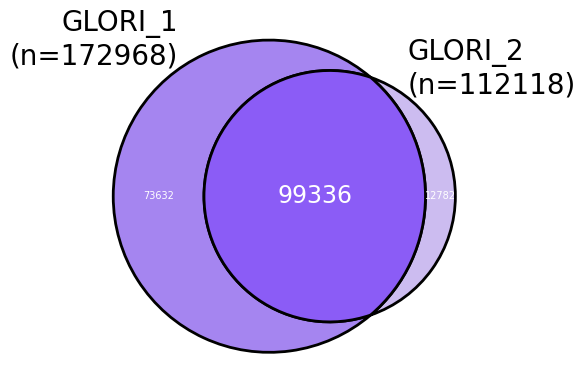

In [47]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles


my_dict2 = {"GLORI_1" : set(GLORI1.pos), "GLORI_2" : set(GLORI2.pos)}
sets = list(my_dict2.values())
df_int = generate_intersections_table(my_dict2)
df_int.to_csv("/home/awiercze/NEW_RNA004_PLOTS/TABLES/PAPER_GLORI_INTERSECTION_blood_m6A.tsv", sep = "\t", index = False)

labels = list(my_dict2.keys())
labels[0] = labels[0] + "\n(n=" + str(len(set(GLORI1.pos)))  + ")"
labels[1] = labels[1] + "\n(n=" + str(len(set(GLORI2.pos))) + ")"

# Create Venn diagram
venn = venn2(subsets=sets, set_labels=labels)


venn.get_patch_by_id('01').set_color("#CCBCF0")   # m6ABasecaller
venn.get_patch_by_id('11').set_color("#8B5CF6")   # mAFiA
venn.get_patch_by_id('10').set_color("#A585F0")   # mAFiA

venn.get_label_by_id('01').set_color("white")   # Dorado + mAFiA
venn.get_label_by_id('11').set_color("white")   # All three
venn.get_label_by_id('10').set_color("white")   # All three

venn.get_label_by_id('10').set_fontsize(7)
venn.get_label_by_id('11').set_fontsize(17)
venn.get_label_by_id('01').set_fontsize(7)

for patch in venn.patches:
    if patch:  # some regions might be empty (None)
        patch.set_edgecolor("black")
        patch.set_linewidth(2)  # adjust thickness as needed
        patch.set_alpha(1)
        print(patch.get_label())



# Change set label font size (those around the circles)
for text in venn.set_labels:
    if text:
        text.set_fontsize(20)
        if (text.get_text() == labels[0]):
            text.set_position([-0.4, 0.65])  # Adjust position for GLORI_1
        else:
            text.set_position([0.4, 0.55])



plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/Overlapping_covered_GLORI_replicates.png", dpi=300, bbox_inches='tight', transparent=True)
plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/Overlapping_covered_GLORI_replicates.pdf", dpi=300, bbox_inches='tight', transparent=True)

plt.show()

# ALL PAIRWISE CORRELATIONS 

## MERGE ALL SAMPLES 

In [48]:
# Subsamples without coverage threshold
mods_subsampled_DORADO = mods_subsampled[mods_subsampled["caller"] == "Dorado@v5.0.0"]
mods_subsampled_DORADO["caller"] = "Dorado@v5.0.0_SUBSAMPLED"
mods_subsampled_DORADO["sample"] = [i + "_SUBSAMPLED" for i in mods_subsampled_DORADO["sample"]]

/tmp/ipykernel_4065922/3714506694.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mods_subsampled_DORADO["caller"] = "Dorado@v5.0.0_SUBSAMPLED"
/tmp/ipykernel_4065922/3714506694.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mods_subsampled_DORADO["sample"] = [i + "_SUBSAMPLED" for i in mods_subsampled_DORADO["sample"]]


In [49]:
p_GLORI = pd.concat([p, mods_subsampled_DORADO, GLORI1, GLORI2, p_m6A_cell], axis = 0)

In [50]:
p_GLORI.loc[p_GLORI["sample"].str.contains("RNA002"), "sample"] = p_GLORI[p_GLORI["sample"].str.contains("RNA002")]["sample"] + "_" + p_GLORI[p_GLORI["sample"].str.contains("RNA002")]["caller"]

In [59]:
p_GLORI["sample_type"] = "blood"
p_GLORI.loc[p_GLORI["sample"].str.contains("UHRR"), "sample_type"] = "UHRR"
p_GLORI.loc[p_GLORI["sample"].str.contains("UHRR"), "sample_type"] = "UHRR"
p_GLORI.loc[p_GLORI["sample"].str.contains("HEK293T"), "sample_type"] = "HEK293T"
p_GLORI.loc[p_GLORI["sample"].str.contains("IVT"), "sample_type"] = "blood_IVT"
p_GLORI_cov = p_GLORI[p_GLORI["coverage"] >= 10]
p_GLORI_cov_m6A = p_GLORI[(p_GLORI["coverage"] >= 10) & (p_GLORI["modRatio"] >= 10)]
df = p_GLORI[p_GLORI.pos.isin(p_GLORI_cov_m6A["pos"].drop_duplicates())]

In [64]:
p_GLORI_cov_m6A.columns =  ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand',
       'coverage', 'modRatio', 'RNA004_UHRR_2', 'RNA004_UHRR_1',
       'RNA004_blood_IVT_1', 'RNA002_HEK293T_B', 'RNA002_blood_IVT', 'RNA004_blood_1',
       'RNA002_UHRR_1', 'RNA002_blood', 'RNA004_UHRR_3', 'RNA004_HEK293T_A',
       'RNA002_HEK293T_A', 'RNA004_HEK293T_B', 'RNA004_blood_3', 'RNA004_S6_IVT_LI',
       'RNA004_S6_IVT', 'RNA004_blood_2', 'sample', 'caller', 'chemistry',
       'pos', 'sample_type']

In [60]:
df.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand',
       'coverage', 'modRatio', 'RNA004_UHRR_2', 'RNA004_UHRR_1',
       'RNA004_blood_IVT_1', 'RNA002_HEK293T_B', 'RNA002_blood_IVT', 'RNA004_blood_1',
       'RNA002_UHRR_1', 'RNA002_blood', 'RNA004_UHRR_3', 'RNA004_HEK293T_A',
       'RNA002_HEK293T_A', 'RNA004_HEK293T_B', 'RNA004_blood_3', 'RNA004_S6_IVT_LI',
       'RNA004_S6_IVT', 'RNA004_blood_2', 'sample', 'caller', 'chemistry',
       'pos', 'sample_type']

In [61]:
df["sample"].drop_duplicates()

0               RNA002_blood_m6ABasecaller
485         RNA002_blood_IVT_m6ABasecaller
489                 RNA002_blood_IVT_mAFiA
535                     RNA002_blood_mAFiA
1055                        RNA004_blood_1
2333594                 RNA004_blood_IVT_1
7813875                     RNA004_blood_2
9558122                     RNA004_blood_3
12917265                RNA004_blood_IVT_3
6                RNA004_blood_3_SUBSAMPLED
1674637          RNA004_blood_1_SUBSAMPLED
3217030          RNA004_blood_2_SUBSAMPLED
0                            GLORI_blood_1
0                            GLORI_blood_2
1                         RNA004_HEK293T_A
2705149                   RNA004_HEK293T_B
6258752                      RNA004_UHRR_2
8364108                      RNA004_UHRR_3
12795407                     RNA004_UHRR_1
Name: sample, dtype: object

In [ ]:

result_rows = []
df = p_GLORI_cov_m6A

# Extract unique samples
samples = df['sample'].unique()

# Iterate over all pairwise combinations of all samples to calculate m6A ratio correlations between shared m6A sites
for s1, s2 in combinations(samples, 2):
    print(s1 + " vs " + s2)

    df1_mod = df[df['sample'] == s1]
    df2_mod = df[df['sample'] == s2]
    
    target = "transcriptome-wide"
    
    if "RNA002" in s1 or "RNA002" in s2:
        df1_mod = df1_mod[df1_mod["chrom"] == "chr20"]    
        df2_mod = df2_mod[df2_mod["chrom"] == "chr20"]
        target = "chr20"
          

    # Positions with coverage >= 10 and modRatio >= 10
    pos_mod1 = set(df1_mod['pos'])
    pos_mod2 = set(df2_mod['pos'])

    # Joined positions
    joined_cov_mod = pos_mod1 & pos_mod2
    
    # Overlap input:
    if "GLORI" in s1 or "GLORI" in s2 or "SUBSAMPLED" in s1 or "SUBSAMPLED" in s2:
        n_joined_cov = "NA"
        df1_mod_joined = df1_mod
        df2_mod_joined = df2_mod
    else:
        if s2 == "RNA004_blood_IVT_3":
            df1_mod_joined = df1_mod[(df1_mod["RNA004_S6_IVT"]  + df1_mod["RNA004_S6_IVT_LI"]) >= 10]
        elif "RNA002_blood_IVT" in s2:
            df1_mod_joined = df1_mod[df1_mod["RNA002_blood_IVT"] >= 10]
        elif "RNA002_blood" in s2:
            df1_mod_joined = df1_mod[df1_mod["RNA002_blood"] >= 10]
        else:
            df1_mod_joined = df1_mod[df1_mod[s2] >= 10]
        
        if s1 == "RNA004_blood_IVT_3":
            df2_mod_joined = df2_mod[(df2_mod["RNA004_S6_IVT"]  + df2_mod["RNA004_S6_IVT_LI"]) >= 10]
        elif "RNA002_blood_IVT" in s1:
            df2_mod_joined = df2_mod[df2_mod["RNA002_blood_IVT"] >= 10]
        elif "RNA002_blood" in s1:
            df2_mod_joined = df2_mod[df2_mod["RNA002_blood"] >= 10]
        else:
            df2_mod_joined = df2_mod[df2_mod[s1] >= 10]
        joined_cov = set(df1_mod_joined['pos']) | set(df2_mod_joined['pos'])
        n_joined_cov = len(joined_cov)
        
    print(len(joined_cov_mod))
    if joined_cov_mod:
        df1_r2 = df1_mod[df1_mod['pos'].isin(joined_cov_mod)].set_index('pos')
        df2_r2 = df2_mod[df2_mod['pos'].isin(joined_cov_mod)].set_index('pos')
        df2_r2 = df2_r2.sort_values(by = "pos")
        df1_r2 = df1_r2.sort_values(by = "pos")
        mod1 = df1_r2.loc[df1_r2.index.isin(joined_cov_mod), 'modRatio']
        mod2 = df2_r2.loc[df1_r2.index.isin(joined_cov_mod), 'modRatio']
        r = pearsonr(mod1, mod2)
        r = r[0]
        corr = round(r, 4)
        print(corr)
        
        #input_set1 = df1_r2
        #input_set2 = df2_r2
        #m = pd.merge(input_set1.reset_index(), input_set2.reset_index(), how = "inner", on = "pos")
        #g = sns.jointplot(x="modRatio_x", y="modRatio_y", data=m, kind='hex', color="#0B3954",     height=3,        # default is 6
        #    ratio=5 )

        # Add correlation coefficient as text
        #g.fig.suptitle(f'Correlation (r) = {corr:.2f}' + f'\n(n = {len(m)})', fontsize=10)
        #g.set_axis_labels(s1,s2)
        #g.ax_joint.set_ylim(0, 100) 
        #g.ax_joint.set_xlim(0, 100) 
        #g.fig.subplots_adjust(top=0.9)  # make room for suptitle
        #comp = s1 + "_vs_" + s2
        #g.savefig("/home/awiercze/NEW_RNA004_PLOTS/Correlation_plot_" + comp + ".m6A.png", transparent=True, dpi = 300)
        #g.savefig("/home/awiercze/NEW_RNA004_PLOTS/Correlation_plot_" + comp + ".m6A.pdf", transparent=True, dpi = 300)
        #plt.close()
    else:
        corr = "NA"

    result_rows.append({
        'Sample1': s1,
        'Sample2': s2,
        "target" : target,
        'n_m6A_ratio>=10.Sample1': len(pos_mod1),
        'n_m6A_ratio>=10.Sample2': len(pos_mod2),
        'n_coverage_filter_passed*.Sample1_Sample2': n_joined_cov,
        'n_m6A_ratio>=10.Sample1_joined_cov': len(df1_mod_joined),
        'n_m6A_ratio>=10.Sample2_joined_cov': len(df2_mod_joined),
        'n_m6A_ratio>=10.Sample1_Sample2': len(joined_cov_mod),
        'mean_m6A_ratio.Sample1_joined_mod' : np.mean(mod1),
        'median_m6A_ratio.Sample1_joined_mod' : np.median(mod1),
        'mean_m6A_ratio.Sample2_joined_mod' : np.mean(mod2) ,
        'median_m6A_ratio.Sample2_joined_mod' : np.median(mod2) ,
        'Correlation_coeff_joined_cov_and_mod': corr
    })
    
# Final result DataFrame
comparison_df = pd.DataFrame(result_rows)
comparison_df.to_csv("/home/awiercze/NEW_RNA004_PLOTS/TABLES/PAPER_TABLE_r2_values_all_pairwise_comps_m6A_new.tsv", sep = "\t", index = False)

RNA002_blood_m6ABasecaller vs RNA002_blood_IVT_mAFiA
12
0.1788
RNA002_blood_m6ABasecaller vs RNA002_blood_mAFiA
176
0.6506
RNA002_blood_m6ABasecaller vs RNA004_blood_1
337
0.6009
RNA002_blood_m6ABasecaller vs RNA004_blood_IVT_1
0
RNA002_blood_m6ABasecaller vs RNA004_blood_2
334
0.5961
RNA002_blood_m6ABasecaller vs RNA004_blood_3
336
0.5945
RNA002_blood_m6ABasecaller vs RNA004_blood_IVT_3
0
RNA002_blood_m6ABasecaller vs RNA004_blood_3_SUBSAMPLED
334
0.577
RNA002_blood_m6ABasecaller vs RNA004_blood_1_SUBSAMPLED
338
0.5961
RNA002_blood_m6ABasecaller vs RNA004_blood_2_SUBSAMPLED
320
0.5916
RNA002_blood_m6ABasecaller vs GLORI_blood_1
327
0.5434
RNA002_blood_m6ABasecaller vs GLORI_blood_2
314
0.5361
RNA002_blood_m6ABasecaller vs RNA004_HEK293T_A
262
0.5449
RNA002_blood_m6ABasecaller vs RNA004_HEK293T_B
278
0.5396
RNA002_blood_m6ABasecaller vs RNA004_UHRR_2
275
0.5726
RNA002_blood_m6ABasecaller vs RNA004_UHRR_3
303
0.5624
RNA002_blood_m6ABasecaller vs RNA004_UHRR_1
286
0.5638
RNA002_blood_IVT

# CREATE COMPLETE TABLE

In [ ]:
df = p_GLORI_cov_m6A
pos_cols = ['chrom', 'chromStart', 'chromEnd', 'strand']

### 1. Boolean detection flags per caller
df['m6A_ratio>=10.RNA002_mAFiA_blood'] = (df['caller'] == 'mAFiA') & (df['coverage'] >= 10) & (df['modRatio'] >= 10)
df['m6A_ratio>=10.RNA002_m6ABasecaller_blood'] = (df['caller'] == 'm6ABasecaller') & (df['coverage'] >= 10) & (df['modRatio'] >= 10)
df['m6A_ratio>=10.RNA004_Dorado_blood'] = (df['caller'] == 'Dorado@v5.0.0') & (df['coverage'] >= 10) & (df['modRatio'] >= 10) & (df['sample_type'] == 'blood')
df['m6A_ratio>=10.RNA004_Dorado_blood_subsampled'] = (df['caller'] == 'Dorado@v5.0.0_SUBSAMPLED') & (df['coverage'] >= 10) & (df['modRatio'] >= 10) & (df['sample_type'] == 'blood')
df['m6A_ratio>=10.RNA004_Dorado_UHRR'] = (df['caller'] == 'Dorado@v5.0.0') & (df['coverage'] >= 10) & (df['modRatio'] >= 10) & (df['sample_type'] == 'UHRR')
df['m6A_ratio>=10.RNA004_Dorado_HEK293T'] = (df['caller'] == 'Dorado@v5.0.0') & (df['coverage'] >= 10) & (df['modRatio'] >= 10) & (df['sample_type'] == 'HEK293T')
df['m6A_ratio>=10.GLORI_blood'] = (df['caller'] == 'GLORI') & (df['coverage'] >= 10) & (df['modRatio'] >= 10)

flags = df.groupby(pos_cols).agg({
    'm6A_ratio>=10.RNA002_mAFiA_blood': 'any',
    'm6A_ratio>=10.RNA002_m6ABasecaller_blood': 'any',
    'm6A_ratio>=10.RNA004_Dorado_blood_subsampled': 'any',
    'm6A_ratio>=10.RNA004_Dorado_blood': 'any',
    'm6A_ratio>=10.GLORI_blood': 'any',
    'm6A_ratio>=10.RNA004_Dorado_UHRR': 'any',
    'm6A_ratio>=10.RNA004_Dorado_HEK293T': 'any'
}).astype(int).reset_index()

### 2. modRatio per sample and position
modratios = df.pivot_table(index=pos_cols, columns='sample', values='modRatio', aggfunc='first').reset_index()
modratios.columns.name = None  # remove index name
samples = ["m6A_freq." + s for s in modratios.columns[4:].to_list()]
my_dict = dict(zip(modratios.columns[4:].to_list(), samples))

modratios = modratios.rename(columns = my_dict)
### 3. Mean modRatio for blood samples (DORADO and GLORI)
blood_mask = df['sample_type'] == 'blood'
mean_modratios = df[blood_mask & df['caller'].isin(['Dorado@v5.0.0','Dorado@v5.0.0_SUBSAMPLED', 'GLORI'])].groupby(pos_cols + ['caller'])['modRatio'].mean().unstack().reset_index()
mean_modratios.columns.name = None
mean_modratios = mean_modratios.rename(columns={
    'Dorado@v5.0.0': 'avg_m6A_ratio.RNA004_Dorado_blood',
    'Dorado@v5.0.0_SUBSAMPLED': 'avg_m6A_ratio.RNA004_Dorado_blood_subsampled',
    'GLORI': 'avg_m6A_ratio.GLORI_blood'
})

cell_mask =  df["sample_type"].isin(["UHRR", "HEK293T", "blood_IVT"])
mean_modratios_cells = df[cell_mask & df['caller'].isin(['Dorado@v5.0.0'])].groupby(pos_cols + ['sample_type'])['modRatio'].mean().unstack().reset_index()
mean_modratios_cells.columns.name = None
mean_modRatio_Dorado_cells = mean_modratios_cells.rename(columns={
    'UHRR': 'avg_m6A_ratio.RNA004_Dorado_UHRR',
    'HEK293T': 'avg_m6A_ratio.RNA004_Dorado_HEK293T',
    "blood_IVT" : 'avg_m6A_ratio.RNA004_Dorado_blood_IVT'
})


### 7. Detected in N callers per position
df['caller_detected'] = ((df['coverage'] >= 10) & (df['modRatio'] >= 10)).astype(int)
detected_callers = df[df['caller_detected'] == 1].groupby(pos_cols)['caller'].nunique().reset_index(name='callers_detected')

detected_tissues = df[(df['caller_detected'] == 1) & (df["caller"] == 'Dorado@v5.0.0')].groupby(pos_cols)['sample_type'].nunique().reset_index(name='Dorado_tissues_detected')

### Final merge
result = flags.merge(mean_modratios, on=pos_cols, how='outer').merge(mean_modRatio_Dorado_cells, on=pos_cols, how='outer').merge(detected_callers, on=pos_cols, how='outer').merge(detected_tissues, on = pos_cols, how = "outer").merge(modratios, on=pos_cols, how='outer')

result = result[~result["Dorado_tissues_detected"].isna()]



#result_annot.df.to_csv("/home/awiercze/NEW_RNA004_PLOTS/PAPER_TABLE_POSITIONS_m6A_annot.tsv", sep = "\t", index = False)

/tmp/ipykernel_2908656/1383810769.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['m6A_ratio>=10.RNA002_mAFiA_blood'] = (df['caller'] == 'mAFiA') & (df['coverage'] >= 10) & (df['modRatio'] >= 10)
/tmp/ipykernel_2908656/1383810769.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['m6A_ratio>=10.RNA002_m6ABasecaller_blood'] = (df['caller'] == 'm6ABasecaller') & (df['coverage'] >= 10) & (df['modRatio'] >= 10)
/tmp/ipykernel_2908656/1383810769.py:7: SettingWithCopyWarning: 
A value is trying to be s

In [247]:
query_ranges = pr.PyRanges(result.rename(columns = {"chrom": "Chromosome", "chromStart" : "Start", "chromEnd" : "End", "strand" : "Strand"}))
gtf_ranges = pr.PyRanges(genes_df.rename(columns = {"chrom": "Chromosome", "start" : "Start", "end" : "End", "strand" : "Strand"}))
result_annot_genes = gtf_ranges.join(query_ranges)
result_annot_genes_df = result_annot_genes.df

result_annot_genes_df["pos"] = result_annot_genes_df["Chromosome"].astype(str) + result_annot_genes_df["End_b"].astype(str) + result_annot_genes_df["Strand_b"].astype(str)
annot_m6A_pos = result_annot_genes_df[["gene_id", "gene_name",  "gene_type", "pos"]].drop_duplicates().groupby("pos")[["gene_id", "gene_name",  "gene_type"]].agg(lambda x: ', '.join(sorted(set(x)))).reset_index()
result["pos"] = result["chrom"].astype(str) + result["chromEnd"].astype(str) + result["strand"].astype(str)

result_annot = pd.merge(annot_m6A_pos, result, how = "right", on = "pos")


In [251]:
result_annot_df_na = result_annot.replace(np.nan, "NA")
mendeliom = pd.read_csv("/raid/awiercze_analysis/RESEARCH/REVISION_FIGURES/mendeliom_IHDB.tsv", sep = "\t")
result_annot_df_na["gene_id_flat"] = [i.split('.')[0] for i in result_annot_df_na.gene_id]
result_annot_df_na["Mendeliome"] = (result_annot_df_na["gene_id_flat"].isin(mendeliom.ensembl_gene_id)).astype(int)

In [253]:
result_annot_df = result_annot_df_na[['gene_name', 'gene_type','gene_id', "Mendeliome", 'chrom', 'chromEnd', 'strand',
       'Dorado_tissues_detected', 
       'm6A_ratio>=10.RNA002_mAFiA_blood',
       'm6A_ratio>=10.RNA002_m6ABasecaller_blood',
       'm6A_ratio>=10.RNA004_Dorado_blood_subsampled',
       'm6A_ratio>=10.RNA004_Dorado_blood', 'm6A_ratio>=10.GLORI_blood',
       'm6A_ratio>=10.RNA004_Dorado_UHRR',
       'm6A_ratio>=10.RNA004_Dorado_HEK293T',
       'avg_m6A_ratio.RNA004_Dorado_blood',
       'avg_m6A_ratio.RNA004_Dorado_blood_subsampled',
       'avg_m6A_ratio.GLORI_blood', 'avg_m6A_ratio.RNA004_Dorado_HEK293T',
       'avg_m6A_ratio.RNA004_Dorado_UHRR',
       'avg_m6A_ratio.RNA004_Dorado_blood_IVT', 'callers_detected',
       'm6A_freq.GLORI_blood_1',
       'm6A_freq.GLORI_blood_2', 'm6A_freq.RNA002_blood_IVT_mAFiA',
       'm6A_freq.RNA002_blood_m6ABasecaller', 'm6A_freq.RNA002_blood_mAFiA',
       'm6A_freq.RNA004_HEK293T_A', 'm6A_freq.RNA004_HEK293T_B',
       'm6A_freq.RNA004_UHRR_1', 'm6A_freq.RNA004_UHRR_2',
       'm6A_freq.RNA004_UHRR_3', 'm6A_freq.RNA004_blood_1',
       'm6A_freq.RNA004_blood_1_SUBSAMPLED', 'm6A_freq.RNA004_blood_2',
       'm6A_freq.RNA004_blood_2_SUBSAMPLED', 'm6A_freq.RNA004_blood_3',
       'm6A_freq.RNA004_blood_3_SUBSAMPLED', 'm6A_freq.RNA004_blood_IVT_1',
       'm6A_freq.RNA004_blood_IVT_3']]

In [258]:
result_annot_df.to_csv("/home/awiercze/NEW_RNA004_PLOTS/PAPER_TABLE_POSITIONS_m6A_annot_NEW2.tsv", sep = "\t", index = False)


In [357]:
result_annot_df_na[result_annot_df_na["gene_id"] != "NA"].to_csv("/home/awiercze/NEW_RNA004_PLOTS/PAPER_TABLE_POSITIONS_m6A_annot_NEW2_genes.tsv", sep = "\t", index = False)

# CREATE COUNTS PLOTS AS BAR PLOT 

In [66]:
p_GLORI_cov10_freq10 = p_GLORI[(p_GLORI["coverage"] >= 10) & (p_GLORI["modRatio"] >= 10)]
p_GLORI_cov10_freq10_num_m6A = p_GLORI_cov10_freq10.groupby(["sample","sample_type", "caller"]).size().reset_index(name = "Number_m6A_sites")

In [67]:
colors_input_2 = {'RNA002_HEK293T_A': '#EE6C4D',
    'RNA002_HEK293T_B': '#E69581',
    'RNA002_blood_m6ABasecaller': "#2081B9",
    'RNA002_blood_IVT_m6ABasecaller': "#fae09a",
    'RNA002_blood_mAFiA': "#1376AF",
    'RNA002_blood_IVT_mAFiA': "#f3cd65",
    'RNA002_UHRR_1': '#098C9A',
    'RNA004_HEK293T_A': '#EE6C4D',
    'RNA004_HEK293T_B': '#E69581',
    'RNA004_blood_1': '#0B3954',
    'RNA004_blood_1_SUBSAMPLED': '#0B3954',
    'RNA004_blood_2_SUBSAMPLED': '#177BB5',
    'RNA004_blood_3_SUBSAMPLED': '#38A6E5',
    "GLORI_blood_1" : '#8b5cf6',
    "GLORI_blood_2" : "#bba3f1",

    'RNA004_blood_IVT_1': "#f1c13d",
    'RNA004_UHRR_1': '#098C9A',
    'RNA004_UHRR_2': '#26AFBE',
    'RNA004_UHRR_3': '#93C6CC',
    'RNA004_blood_2': '#177BB5',
    'RNA004_blood_3': '#38A6E5',
    'RNA004_blood_IVT_3': "#f0b617",
    'RNA004_blood_IVT_3_R2': '#E3D8FD',
    'RNA002_blood_1_rodan': '#098C9A',
    'RNA002_blood_1_m6ABasecaller': '#098C9A',
    'mAFiA': '#098C9A',
    'm6ABasecaller': '#ee6c4d',
    'Dorado': '#0B3954'}

/tmp/ipykernel_4065922/1880115257.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")


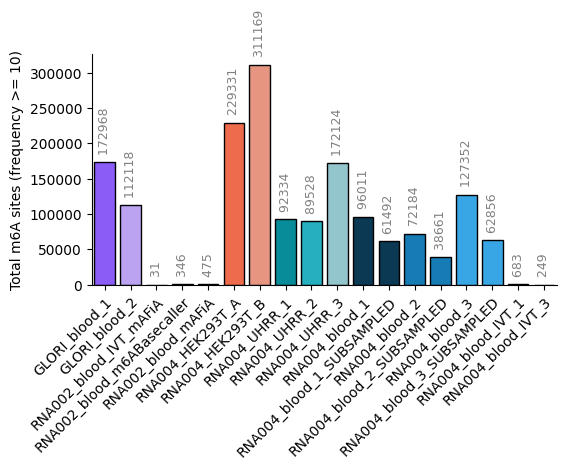

In [68]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(data = p_GLORI_cov10_freq10_num_m6A, hue = "sample", x="sample", edgecolor ="black", y="Number_m6A_sites",saturation=1, palette = colors_input_2)
ax.spines['left'].set_color('black')   # Left axis line
ax.spines['bottom'].set_color('black') 
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):  # avoid labeling bars with NaN height
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 1,  # small offset above bar
            s=f"  {int(height)}",  # or f"{height:.1f}" for float
            ha="center",
            va="bottom",
            rotation=90,
            fontsize=9,
            color = "gray"
        )
ax.set_ylabel("Total m6A sites (frequency >= 10)")
ax.set_xlabel("")
i = "all_samples"
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE4/PAPER_m6a_count_" + i + "_RNA004_tissue_bar.png", bbox_inches='tight', dpi=300)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE4/PAPER_m6a_count_" + i + "_RNA004_tissue_bar.pdf", bbox_inches='tight', dpi=300)



# THRESHOLD COMPARISONS

In [21]:
blood_RNA004_filt = glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/*S5*m6A*filtered*") 

In [78]:
blood_RNA004_filt = ['/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.NO_DRACH.r2.mod.bed',
 '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.NO_THRESHOLD.r2.mod.bed',
 '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.NO_DRACH_NO_THRESHOLD.r2.mod.bed',
 '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.r1.mod.bed']

In [79]:
replace_dict = {
 'RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.NO_DRACH.r2.mod.bed' : "RNA004_blood_2_NO_DRACH_p098",
 'RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.NO_THRESHOLD.r2.mod.bed' : "RNA004_blood_2_DRACH_10thpercentile",
 'RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.NO_DRACH_NO_THRESHOLD.r2.mod.bed' : "RNA004_blood_2_NO_DRACH_10thpercentile",
 'RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.r1.mod.bed': "RNA004_blood_2_DRACH_p098"
}

In [83]:
p_THRESHOLD = pd.DataFrame()
for j in blood_RNA004_filt:
    print(j)
    t_tmp = pd.read_csv(j, sep = "\t", header = None)
    print(len(t_tmp))

    t_tmp.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', "mod_start", "mod_end", "color", "coverage", "modRatio", "n_mod", "n_canonical", "n_other_mod", "n_delete", "n_fail", "n_diff", "n_nocall"]
    caller = "Dorado@v5.0.0"
    t_tmp = t_tmp[["chrom", "chromStart", "chromEnd", "name", "score", "strand", "coverage", "modRatio"]]

    sample_name = j.split("/")[-1]
    print(sample_name)
    for word, initial in replace_dict.items():
        sample_name = sample_name.replace(word, initial)
    print(sample_name)
    t_tmp["sample"] =sample_name

    t_tmp["caller"] = caller
    t_tmp["chemistry"] = "RNA004"
    p_THRESHOLD = pd.concat([p_THRESHOLD, t_tmp], axis = 0)
    
p_THRESHOLD = p_THRESHOLD.reset_index()
p_THRESHOLD = p_THRESHOLD.drop("index", axis = 1)
p_THRESHOLD["chromStart"] = p_THRESHOLD["chromStart"].astype(int)
p_THRESHOLD["chromEnd"] = p_THRESHOLD["chromEnd"].astype(int)
p_THRESHOLD["coverage"] = p_THRESHOLD["coverage"].astype(int)
p_THRESHOLD["modRatio"] = p_THRESHOLD["modRatio"].astype(float)

p_THRESHOLD = p_THRESHOLD[p_THRESHOLD["chrom"].str.contains("chr")]
p_THRESHOLD["pos"] = p_THRESHOLD["chrom"] + ":" + p_THRESHOLD["chromStart"].astype(str) + "" + p_THRESHOLD["strand"]
    

/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.NO_DRACH.r2.mod.bed
24615724
RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.NO_DRACH.r2.mod.bed
RNA004_blood_2_NO_DRACH_p098
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.NO_THRESHOLD.r2.mod.bed
1751941
RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.NO_THRESHOLD.r2.mod.bed
RNA004_blood_2_DRACH_10thpercentile
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.NO_DRACH_NO_THRESHOLD.r2.mod.bed
25051308
RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.NO_DRACH_NO_THRESHOLD.r2.mod.bed
RNA004_blood_2_NO_DRACH_10thpercentile
/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/m6A_pseu_refilter_rev1_nar1/RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.r1.mod.bed
1744247
RNA004_S5_DRS_basecall.0.7.2.GRCh38_m6A.r1.mod.bed
RNA004_blood_2_DRACH_p098


In [85]:
p_THRESHOLD_GLORI = pd.concat([p_THRESHOLD, GLORI1, GLORI2], axis = 0)

In [102]:
p_THRESHOLD_GLORI["sample_type"] = "GLORI"
p_THRESHOLD_GLORI.loc[p_THRESHOLD_GLORI["sample"].str.contains("DRACH_p098"), "sample_type"] = "DRACH_p098"
p_THRESHOLD_GLORI.loc[p_THRESHOLD_GLORI["sample"].str.contains("DRACH_10thpercentile"), "sample_type"] = "DRACH_10thpct"
p_THRESHOLD_GLORI.loc[p_THRESHOLD_GLORI["sample"].str.contains("NO_DRACH_10thpercentile"), "sample_type"] = "NO_DRACH_10thpct"
p_THRESHOLD_GLORI.loc[p_THRESHOLD_GLORI["sample"].str.contains("NO_DRACH_p098"), "sample_type"] = "NO_DRACH_p098"

In [103]:
result_rows = []
df = p_THRESHOLD_GLORI
samples = df['sample'].unique()

for i in samples:
    print(i)
    df_sample = df[df['sample'] == i]
    n_raw = len(df_sample)
    print(n_raw)
    df_sample_filt = df_sample[(df_sample["coverage"] >= 10) & (df_sample["modRatio"] >= 10)]
    n_filt = len(df_sample_filt)
    
    list_overlaps = []
    for j in samples:
        if i == j:
            list_overlaps.append(n_filt)
        else:
            df_sample2_filt = df[(df["coverage"] >= 10) & (df["modRatio"] >= 10) & (df["sample"] == j)]
            list_overlaps.append(len(df_sample_filt[df_sample_filt["pos"].isin(df_sample2_filt["pos"])]))
    false_negatives1 = GLORI1[~GLORI1["pos"].isin(df_sample_filt["pos"])]
    false_negatives2 = GLORI2[~GLORI2["pos"].isin(df_sample_filt["pos"])]
    false_negatives = len(set(false_negatives1["pos"]) & set (false_negatives2["pos"]))
    false_positives1 = df_sample_filt[~df_sample_filt["pos"].isin(GLORI1["pos"])]
    false_positives2 = df_sample_filt[~df_sample_filt["pos"].isin(GLORI2["pos"])]
    false_positives = len(set(false_positives1["pos"]) & set (false_positives2["pos"]))
    
    result_rows.append({
            'Sample': i,
            'condition' : df_sample_filt["sample_type"].unique()[0],
            'n_total': n_raw,
            "n_cov>=10_m6Afreq>=10" : n_filt,
            'n_false_negatives': false_negatives,
            'false_negatives_rate (FN/TP+FN)' : (false_negatives/len(set(GLORI1["pos"]) | set(GLORI2["pos"])))*100,
            'n_false_positives': false_positives,
            'n_FP/n_m6A_sites': false_positives/n_filt*100,
            'perc_overlap_NO_DRACH_p098': list_overlaps[0]/n_filt*100,
            'perc_overlap_DRACH_10thpercentile': list_overlaps[1]/n_filt*100,
            'perc_overlap_NO_DRACH_10thpercentile': list_overlaps[2]/n_filt*100,
            'perc_overlap_DRACH_p098' : list_overlaps[3]/n_filt*100, 
            'perc_overlap_GLORI_1' : list_overlaps[4]/n_filt*100,
            'perc_overlap_GLORI_2' :list_overlaps[5]/n_filt*100 
        })

        
# Final result DataFrame
comparison_df = pd.DataFrame(result_rows)
comparison_df = comparison_df.sort_values(by = ["Sample"])
comparison_df = comparison_df[comparison_df["condition"] != "GLORI"]
comparison_df.to_csv("/home/awiercze/NEW_RNA004_PLOTS/TABLES/PAPER_TABLE_THRESHOLD_COMPARISONS.tsv", sep = "\t", index = False)
    

RNA004_blood_2_NO_DRACH_p098
24580722
RNA004_blood_2_DRACH_10thpercentile
1749758
RNA004_blood_2_NO_DRACH_10thpercentile
25015022
RNA004_blood_2_DRACH_p098
1742082
GLORI_blood_1
172968
GLORI_blood_2
112118
